# Is the S&P 500 a relevant predictor of various stocks, cryptocurrencies, or macroeconomic factors?

### IEOR E4150 Class Project
#### Joseph High (UNI: jph2185)

This project seeks to assess the relationship between the S\&P 500 index fund and stocks of large companies that are not included in the list of companies under the S\&P 500 index. We will further this analysis by comparing the S\&P 500 index fund to four stocks whose underlying companies are among the largest components that make up the S\&P 500 index. Finally, we will assess the whether the S\&P 500 is a good indicator (or predictor) of the U.S. housing marking, via the national Housing Price Index (HPI). 

<a href='#part1'>Part 1: Assessing S&P 500 against Non-S&P 500 Stocks</a> 

<a href='#part2'>Part 2: Assessing S&P 500 against Large S&P 500 Companies</a>

<a href='#part3'>Part 3: Regression of log-returns on time for individual stocks</a>

<a href='#part4'>Part 4: Assessing S&P 500 against HPI</a>


#### Package installation and import
The following packages must be installed on your computer in order to run this notebook to completion. If you do not already have these installed, please uncomment the pip commands below and run them. 

In [1]:
## Install the following packages in case not already on installed on your machine.

# !pip install pandas_datareader
# !pip install yfinance

In [2]:
%run 'functions_for_project.ipynb'

In [3]:
import pandas as pd      
import numpy as np
import math

# Import data visualation and plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=2)
plt.style.use("seaborn")

# Statistical analysis libraries
import scipy.stats as stats
import statistics as st
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.sandbox.stats.runs import runstest_1samp 
import pylab as py

# Packages to be used to extract NYSE stock data and create/manipulate datetime objects
import yfinance as yf
import pandas_datareader
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import datetime
from datetime import date

<a id='part1'></a>
### Part 1: Assessing S&P 500 against public companies NOT in the S&P 500
##### Companies evaluated against S&P 500:
<li> Uber (NYSE Ticker: UBER)
<li> Zillow (NYSE Ticker: ZG)
<li> Block, Inc. (NYSE Ticker: SQ)
<li> Snap, Inc. (NYSE Ticker: SNAP)

Uber had the most recent IPO which occurred on May 10, 2019. Therefore, we only go as far back as this date. 

In [4]:
tickers = ['UBER','ZG','SQ','SNAP']
start = date(2019,5,10) 
end = date(2022,4,26)
stock_df = pdr.get_data_yahoo(tickers, start, end)

In [5]:
close_price_df = stock_df['Adj Close']
close_price_df.index = pd.to_datetime(close_price_df.index)
close_price_df

Symbols,UBER,ZG,SQ,SNAP
Date,,,,
2019-05-10,41.570000,35.410000,65.989998,10.490000
2019-05-13,37.099998,35.459999,62.389999,10.110000
2019-05-14,39.959999,36.540001,64.110001,10.490000
2019-05-15,41.290001,38.279999,65.230003,10.660000
2019-05-16,43.000000,38.830002,66.400002,11.420000
...,...,...,...,...
2022-04-20,33.209999,43.610001,114.519997,30.760000
2022-04-21,31.680000,41.790001,107.709999,29.420000
2022-04-22,30.830000,41.150002,102.669998,29.760000


In [6]:
sp500_data = pd.read_csv("./Data/SP500_HistoricalPrices.csv",index_col="Date")
sp500_close_price = sp500_data[' Close']
sp500_close_price.index = pd.to_datetime(sp500_close_price.index)
sp500_close_price = sp500_close_price[(sp500_close_price.index>='2019-05-10') & 
                                      (sp500_close_price.index<'2022-04-27')]

In [7]:
# Combine non-S&P data with S&P 500 prices
df1 = pd.concat([close_price_df, sp500_close_price], axis=1)
df1.dropna(inplace = True)

In [8]:
old_name = [' Close']
new_name = ['SP500']
df1.rename(columns = dict(zip(old_name, new_name)), inplace = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 747 entries, 2019-05-10 to 2022-04-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UBER    747 non-null    float64
 1   ZG      747 non-null    float64
 2   SQ      747 non-null    float64
 3   SNAP    747 non-null    float64
 4   SP500   747 non-null    float64
dtypes: float64(5)
memory usage: 35.0 KB


##### Compute daily log-returns for each stock and S&P 500 closing prices

In [9]:
# Compute daily log-returns:
for name in df1:
    df1[name + ' Daily Log-Return'] = np.log(df1[name]) - np.log(df1[name].shift(1))

In [10]:
df1_returns = df1[['UBER Daily Log-Return', 'ZG Daily Log-Return', 'SQ Daily Log-Return', 
          'SNAP Daily Log-Return', 'SP500 Daily Log-Return']]

# Remove 05-10-2019 entry since log-return cannot be computed for the first value in the series
df1_returns = df1_returns[1:]

In [11]:
# df1_returns
old_name = ['UBER Daily Log-Return', 'ZG Daily Log-Return', 'SQ Daily Log-Return', 
          'SNAP Daily Log-Return', 'SP500 Daily Log-Return']
new_name = ['UBER', 'ZG', 'SQ','SNAP', 'SP500']
df1_returns.rename(columns = dict(zip(old_name, new_name)), inplace = True)
df1_returns

,UBER,ZG,SQ,SNAP,SP500
Date,,,,,
2019-05-13,-0.113762,0.001411,-0.056098,-0.036897,-0.024427
2019-05-14,0.074262,0.030002,0.027195,0.036897,0.007984
2019-05-15,0.032741,0.046520,0.017319,0.016076,0.005822
2019-05-16,0.040580,0.014266,0.017778,0.068868,0.008856
2019-05-17,-0.025676,0.024171,-0.016552,0.006111,-0.005854
...,...,...,...,...,...
2022-04-20,-0.017610,-0.066529,-0.092512,-0.089203,-0.000619
2022-04-21,-0.047165,-0.042629,-0.061307,-0.044540,-0.014863
2022-04-22,-0.027197,-0.015433,-0.047922,0.011490,-0.028132


In [12]:
ticker_list = ['UBER','ZG','SQ','SNAP','SP500']
nonSP_list = ['UBER','ZG','SQ','SNAP']
nonSP_company_name = ["Uber","Zillow", "Block, Inc.", "Snap, Inc."]

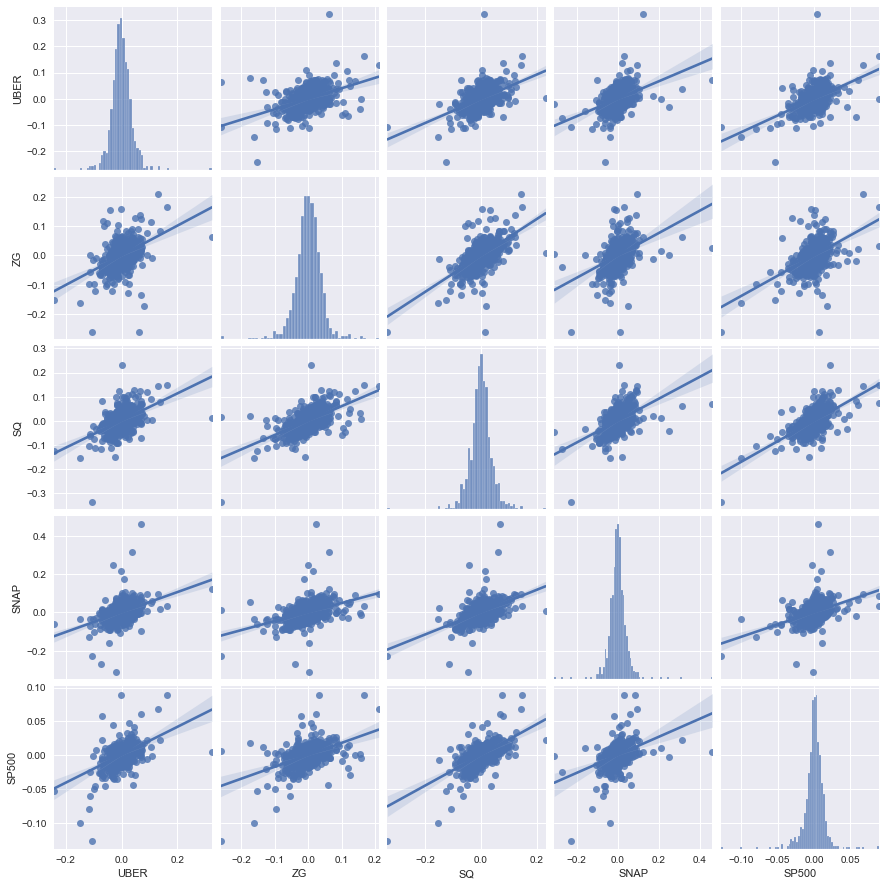

In [13]:
%matplotlib inline
plt.style.use('seaborn')

# sns.set(rc={'figure.figsize':(8,8)}, font_scale=1.15)
# sns.set(font_scale=1.15)
sns.pairplot(df1_returns, kind='reg')
plt.savefig('figures/nonSP_pairplot.png',bbox_inches='tight',pad_inches=0.1)

Wald-Wolfowitz Runs tests to check that data are independent random samples

In [14]:
def runs_test(df, com_list): 
    for i, ticker in enumerate(com_list):
        rt_results = runstest_1samp(df[ticker])
        print('Runs test for', ticker)
        print('================================')
        print('test stat: ', rt_results[0])
        print('p-value:   ', rt_results[1], '\n\n')

In [15]:
runs_test(df=df1_returns,com_list=ticker_list)

Runs test for UBER
test stat:  0.6757756643741002
p-value:    0.4991830877445613 


Runs test for ZG
test stat:  -1.5451342514577728
p-value:    0.12231379367738925 


Runs test for SQ
test stat:  -0.6471951313598885
p-value:    0.5175056619193031 


Runs test for SNAP
test stat:  0.9576506187059054
p-value:    0.33823896527784325 


Runs test for SP500
test stat:  1.5550015814841742
p-value:    0.11994569267805746 




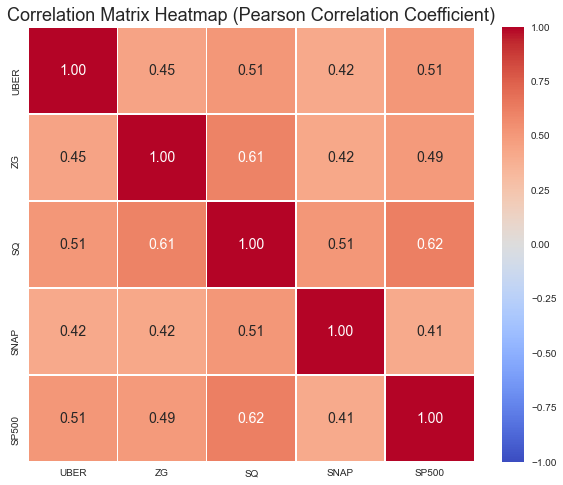

In [16]:
title = 'Correlation Matrix Heatmap (Pearson Correlation Coefficient)'
df_x = df1_returns.copy()
matrix_x = df_x.corr(method='pearson')

## Plot heatmap of the correlation matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix_x,vmin=-1, vmax=1, cmap='coolwarm',fmt= '0.2f', 
                 annot_kws={"size":14}, linewidth=0.5, annot=True)
# sns.set(font_scale=3.2) 
plt.title(title,fontsize=18)

plt.savefig('figures/pearson_corr_heatmap_nonSP.png',bbox_inches='tight')

In [17]:
def dens_histograms(df, company_list=[], company_name=[], sp500_stocks=False, num_cols=2, num_rows=3, part_num=''):
    %matplotlib inline
    plt.style.use("seaborn")
    
    if (sp500_stocks==False):
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
        fig.delaxes(axes[2,1]) # deletes the 6th plot instance (since we are computing an odd number of plots)

        colors = ['navy','firebrick','darkviolet','brown','forestgreen']
        for i, company in enumerate(company_list):
            ax = axes[int(i/num_cols), i%num_cols]
            sns.distplot(df[company], hist=True, fit=norm, ax=ax, color=colors[i], 
                         hist_kws={"alpha": 0.5})
            ax.set_xlabel('Daily Log-Return', fontsize=14)
            ax.set_ylabel('Frequency', fontsize=14)
            ax.set_title(company, fontsize=18) 

        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.21)
        plt.savefig('figures/part'+part_num+'_nonSP500_histograms.png',bbox_inches='tight',pad_inches=0.1)
        plt.show()
    
    else:
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,15))

        colors = ['navy','firebrick','darkviolet','forestgreen']
        for i, company in enumerate(company_list):
            ax = axes[int(i/num_cols), i%num_cols]
            sns.distplot(company['Daily Log-Return'], hist=True, fit=norm, ax=ax, color=colors[i], 
                         hist_kws={"alpha": 0.5})
            ax.set_xlabel('Daily Log-Return', fontsize=14)
            ax.set_ylabel('Frequency', fontsize=14)
            ax.set_title(company_name[i], fontsize=18) 

        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.21)
        plt.savefig('figures/part'+part_num+'_sp500_stocks_histograms.png',bbox_inches='tight',pad_inches=0.1)
        plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

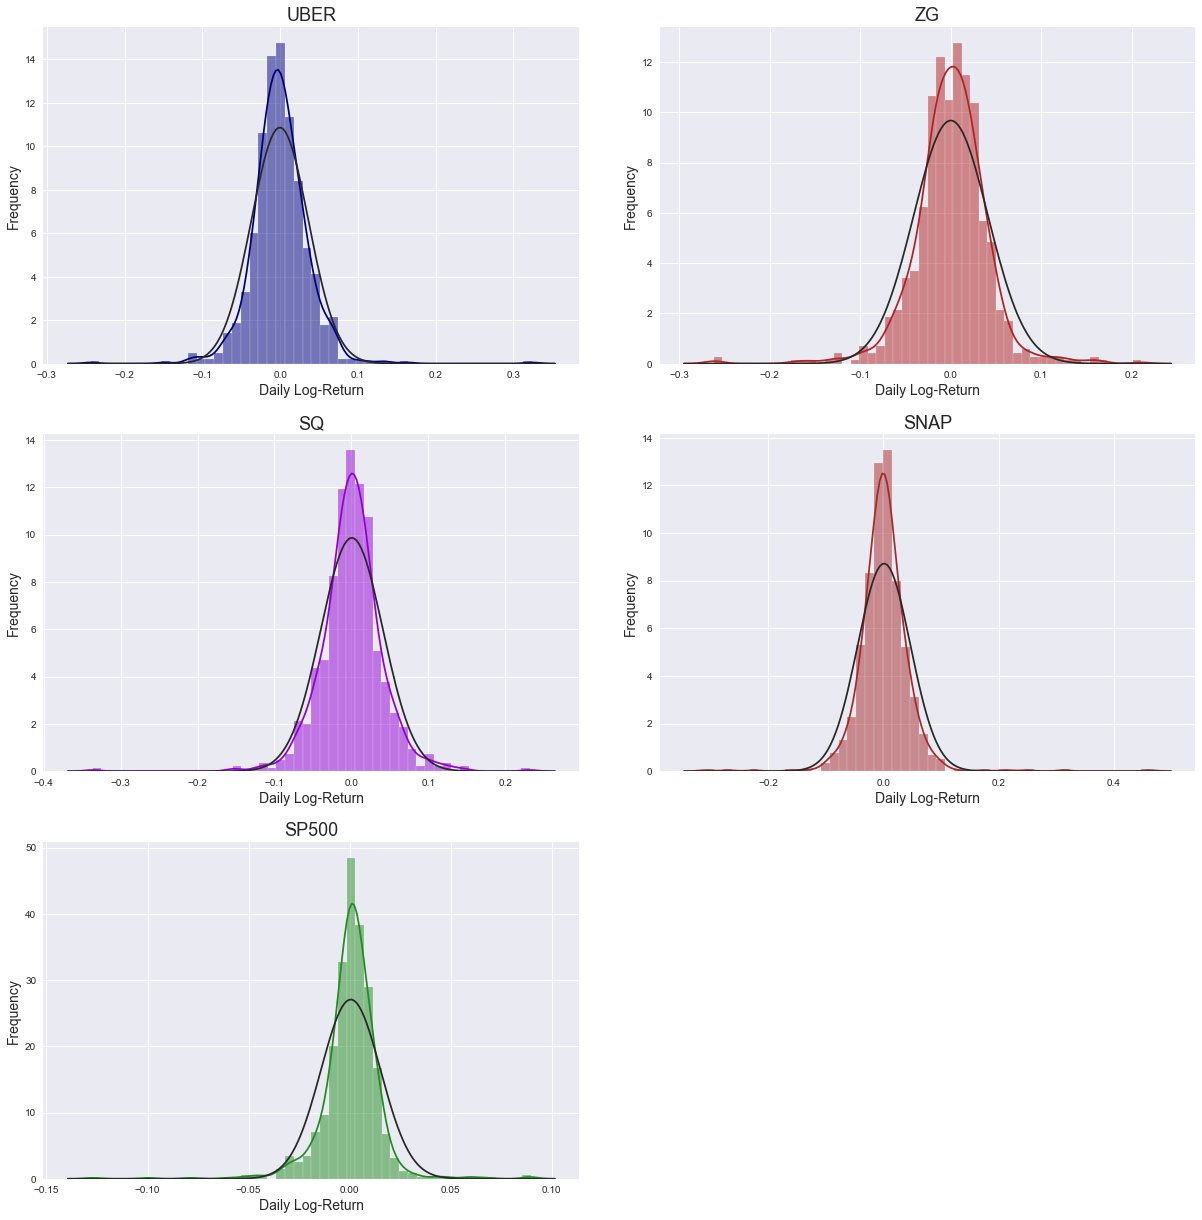

In [18]:
dens_histograms(df1_returns,company_list=ticker_list,part_num='1')

In [19]:
def norm_qqplot(df, company_list=[], mod_list=[], resid_bool=False, num_cols=2, num_rows=3, part_num=''):
    %matplotlib inline
    plt.style.use("seaborn")
    
    if(resid_bool == False):
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
        axes.flatten()
        fig.delaxes(axes[2,1]) 
        for i, company in enumerate(company_list):
            ax = axes[int(i/num_cols), i%num_cols]
            qqplot(df[company], dist=norm, fit=True, line ='q',ax=ax)
            ax.set_title('Normal Q-Q Plot for '+ company + ' Log-Returns', fontsize=16)
            sns.despine()
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.22)
        plt.savefig('figures/part'+part_num+'_stock_qqplots.png')
        plt.show()
    else:
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,15))
        axes.flatten() 
        for i, model in enumerate(model_list):
            ax = axes[int(i/num_cols), i%num_cols]
            qqplot(model.resid, dist=norm, fit=True, line ='q',ax=ax)
            ax.set_title('Normal Q-Q Plot for '+ company_list[i] + ' ~ SP500 Residuals', fontsize=16)
            sns.despine()
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.22)
        plt.savefig('figures/part'+part_num+'_residual_qqplots.png')
        plt.show()

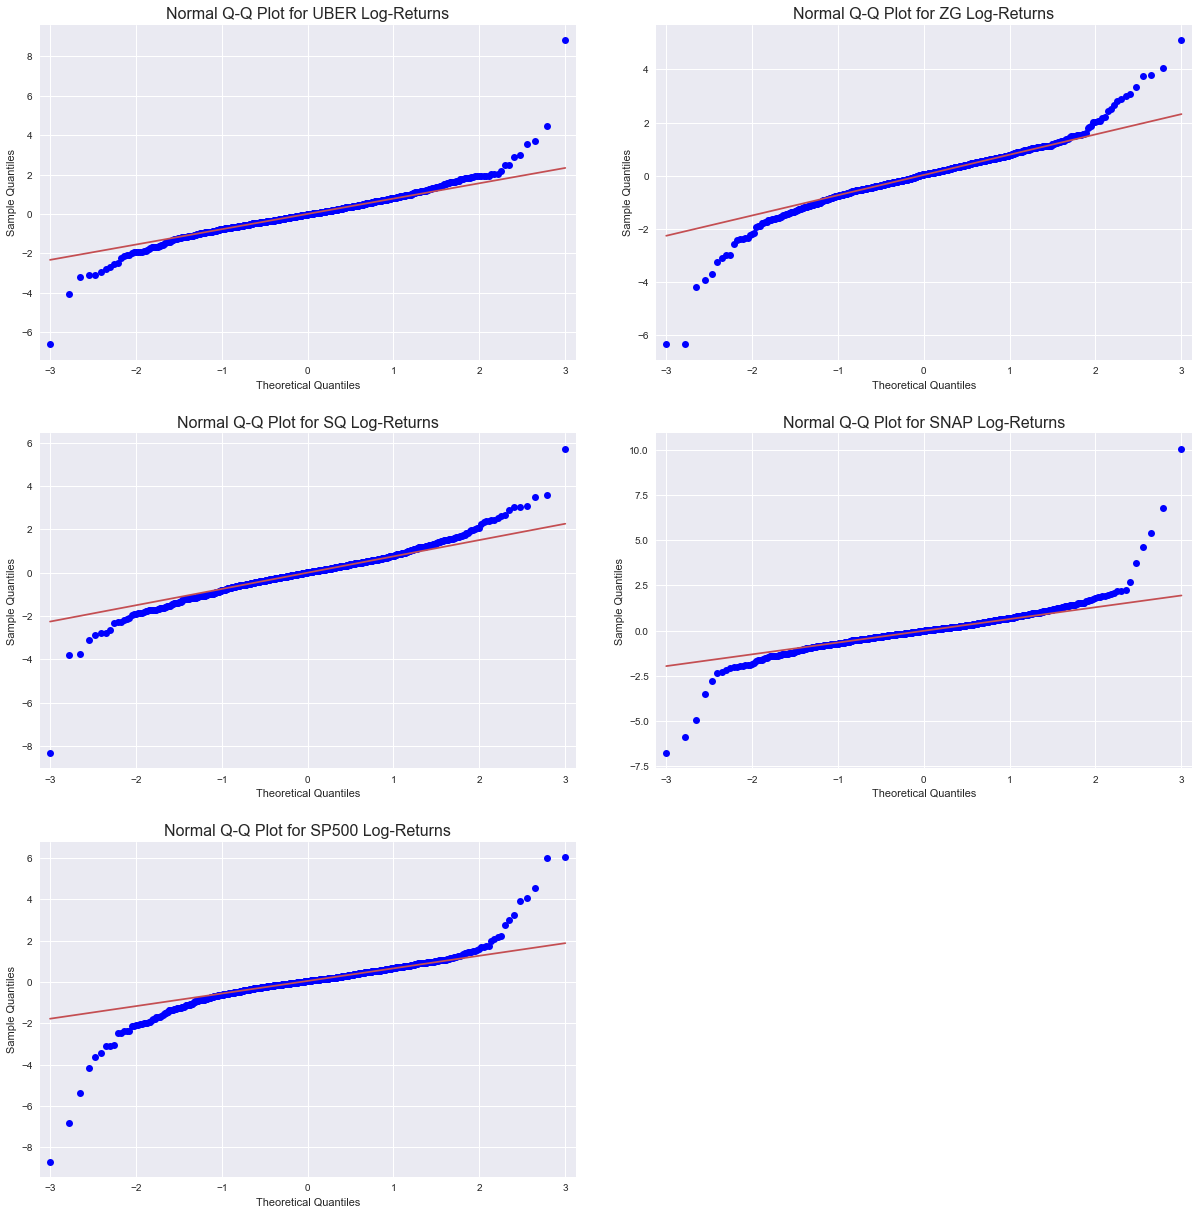

In [20]:
norm_qqplot(df1_returns,ticker_list,part_num='1')

##### Fit Linear Regression Models for Non-S&P 500 stocks
For each non-S&P 500 stock, a simple linear regression of the log-returns of the stock on the S&P 500 log-returns is fit.

In [21]:
# Linear Regression of UBER log-returns (dep. variable) on SP500 log-returns (ind. variable)
uber_lr = smf.ols(formula='UBER ~ SP500', data=df1_returns)
uber_model_fit = uber_lr.fit()
print(uber_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   UBER   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     266.4
Date:                Sun, 01 May 2022   Prob (F-statistic):           2.02e-51
Time:                        05:38:17   Log-Likelihood:                 1520.8
No. Observations:                 746   AIC:                            -3038.
Df Residuals:                     744   BIC:                            -3028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.001     -0.878      0.3

In [22]:
# Linear Regression of ZG log-returns (dep. variable) on SP500 log-returns (ind. variable)
zg_lr = smf.ols(formula='ZG ~ SP500', data=df1_returns)
zg_model_fit = zg_lr.fit()
print(zg_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     ZG   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     240.7
Date:                Sun, 01 May 2022   Prob (F-statistic):           3.11e-47
Time:                        05:38:17   Log-Likelihood:                 1424.5
No. Observations:                 746   AIC:                            -2845.
Df Residuals:                     744   BIC:                            -2836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0006      0.001     -0.437      0.6

In [23]:
# Linear Regression of SQ log-returns (dep. variable) on SP500 log-returns (ind. variable)
sq_lr = smf.ols(formula='SQ ~ SP500', data=df1_returns)
sq_model_fit = sq_lr.fit()
print(sq_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     SQ   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     467.3
Date:                Sun, 01 May 2022   Prob (F-statistic):           8.38e-81
Time:                        05:38:17   Log-Likelihood:                 1516.3
No. Observations:                 746   AIC:                            -3029.
Df Residuals:                     744   BIC:                            -3019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.001     -0.244      0.8

In [24]:
# Linear Regression of SNAP log-returns (dep. variable) on SP500 log-returns (ind. variable)
snap_lr = smf.ols(formula='SNAP ~ SP500', data=df1_returns)
snap_model_fit = snap_lr.fit()
print(snap_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   SNAP   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     153.6
Date:                Sun, 01 May 2022   Prob (F-statistic):           3.33e-32
Time:                        05:38:17   Log-Likelihood:                 1312.3
No. Observations:                 746   AIC:                            -2621.
Df Residuals:                     744   BIC:                            -2611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.002      0.465      0.6

In [25]:
model_list = [uber_model_fit, zg_model_fit, sq_model_fit, snap_model_fit]

def lr_plots(df, mod_list, com_list, num_cols=2,num_rows=2,part_num='', fig_size=(20,14), time_bool=False):
    %matplotlib inline
    plt.style.use("seaborn")
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size)
    if (time_bool==False):
        for i, model in enumerate(mod_list):
            ax = axes[int(i/num_cols), i%num_cols]
            intercept = model.params[0]
            slope=model.params[1]
            x = df.SP500
            y = df[com_list[i]]
            ax.plot(x, y, 'o', label='original data')
            ax.plot(x, intercept + slope*x, 'k', label='fitted line')
            ax.set_title(com_list[i] + ' ~ SP500',fontsize=16)
            ax.legend()

        plt.savefig('figures/part'+part_num+'_lr_plots.png')
        plt.show()
    else:
        for i, model in enumerate(mod_list):
            ax = axes[int(i/num_cols), i%num_cols]
            intercept = model.params[0]
            slope=model.params[1]
            x = df.SP500
            y = df[com_list[i]]
            ax.plot(x, y, 'o', label='original data')
            ax.plot(x, intercept + slope*x, 'k', label='fitted line')
            ax.set_title(com_list[i] + ' ~ time',fontsize=16)
            ax.legend()

        plt.savefig('figures/part'+part_num+'_time_lr_plots.png')
        plt.show()

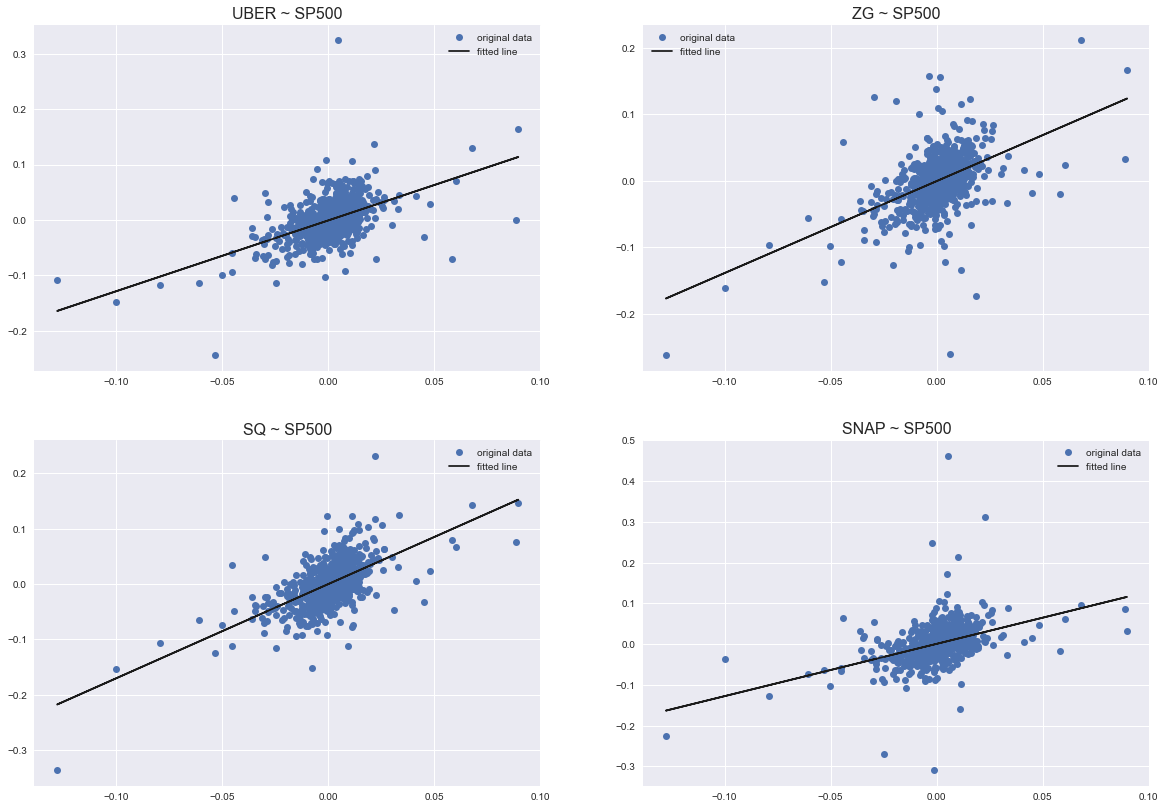

In [26]:
lr_plots(df1_returns, model_list, ticker_list, part_num='1')

In [27]:
def one_way_anova(df, com_list):
    print('One-Way ANOVA tests the equality of two population means \n')
    for i, ticker in enumerate(com_list):
        anova = stats.f_oneway(df[ticker], df.SP500)
        print('One-Way ANOVA Test for', ticker, 'and SP500')
        print('=====================================')
        print('F-statistic: ', anova.statistic)
        print('p-value:     ', anova.pvalue, '\n\n')

In [28]:
one_way_anova(df=df1_returns, com_list=nonSP_list)

One-Way ANOVA tests the equality of two population means 

One-Way ANOVA Test for UBER and SP500
F-statistic:  0.3653818573587359
p-value:      0.5456244063297945 


One-Way ANOVA Test for ZG and SP500
F-statistic:  0.05736773013425412
p-value:      0.8107387319114412 


One-Way ANOVA Test for SQ and SP500
F-statistic:  0.0017680305390723858
p-value:      0.966466102743739 


One-Way ANOVA Test for SNAP and SP500
F-statistic:  0.23368278489314756
p-value:      0.6288774700212472 




In [29]:
def eq_means_t_test(df,com_list):
    print('This also tests the equality of two population means \n') 
    for i, ticker in enumerate(com_list):
        two_pop_t_test = stats.ttest_ind(df[ticker], df.SP500)
        print('T-test for Means of', ticker, 'and SP500')
        print('==================================')
        print('t-statistic: ', two_pop_t_test.statistic)
        print('p-value:     ', two_pop_t_test.pvalue, '\n\n')

In [30]:
eq_means_t_test(df=df1_returns,com_list=nonSP_list)

This also tests the equality of two population means 

T-test for Means of UBER and SP500
t-statistic:  -0.6044682434658879
p-value:      0.545624406330045 


T-test for Means of ZG and SP500
t-statistic:  -0.23951561563759088
p-value:      0.8107387319116283 


T-test for Means of SQ and SP500
t-statistic:  0.04204795523057399
p-value:      0.9664661027441138 


T-test for Means of SNAP and SP500
t-statistic:  0.48340747293887437
p-value:      0.6288774700214008 




Text(0.5, 1.0, 'Regression Plots for UBER ~ SP500')

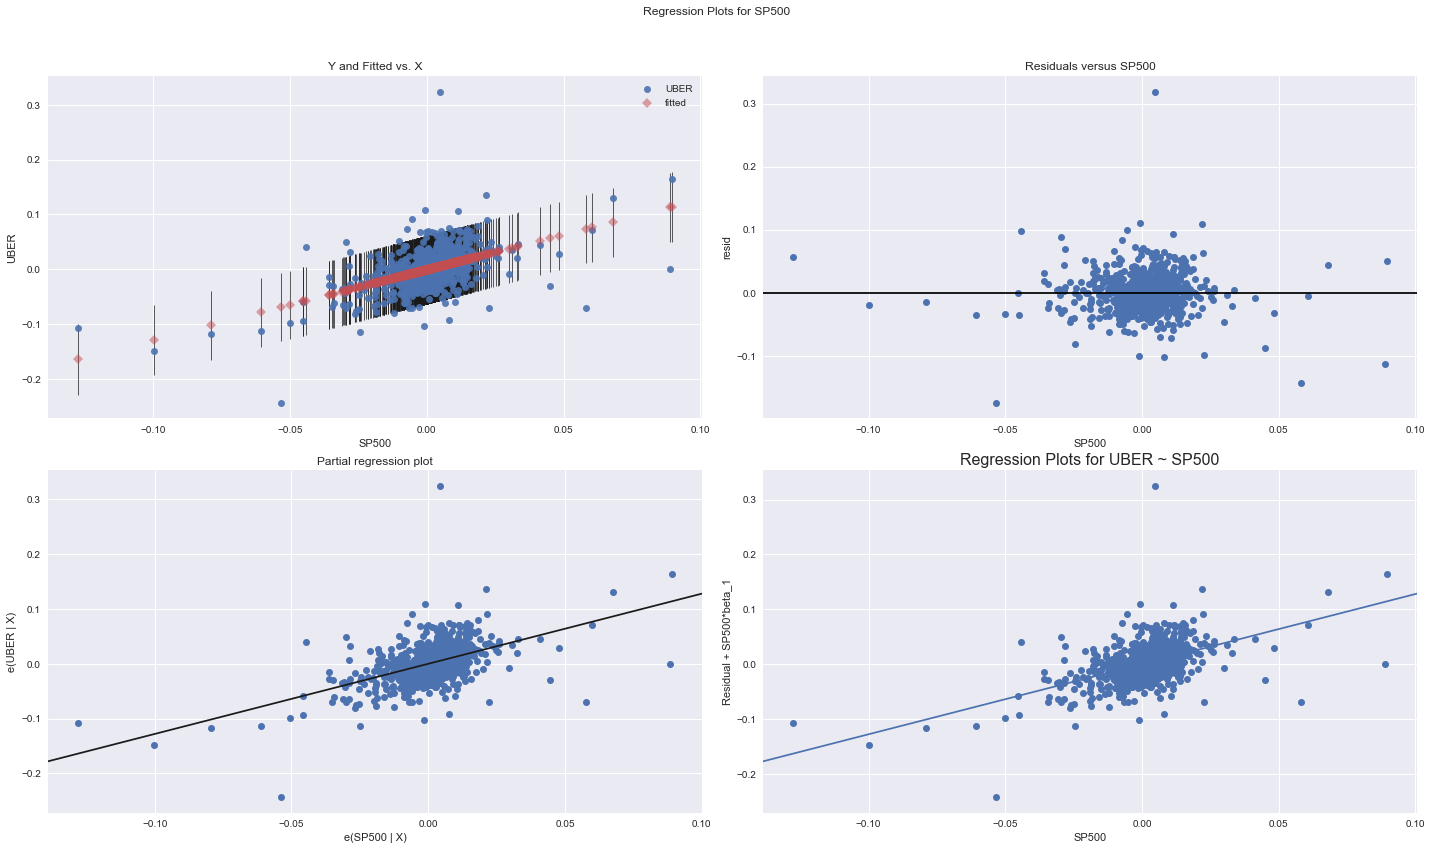

In [31]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_regress_exog(uber_model_fit, "SP500", fig)
plt.title('Regression Plots for UBER ~ SP500',fontsize=16)

Text(0.5, 1.0, 'Regression Plots for ZG ~ SP500')

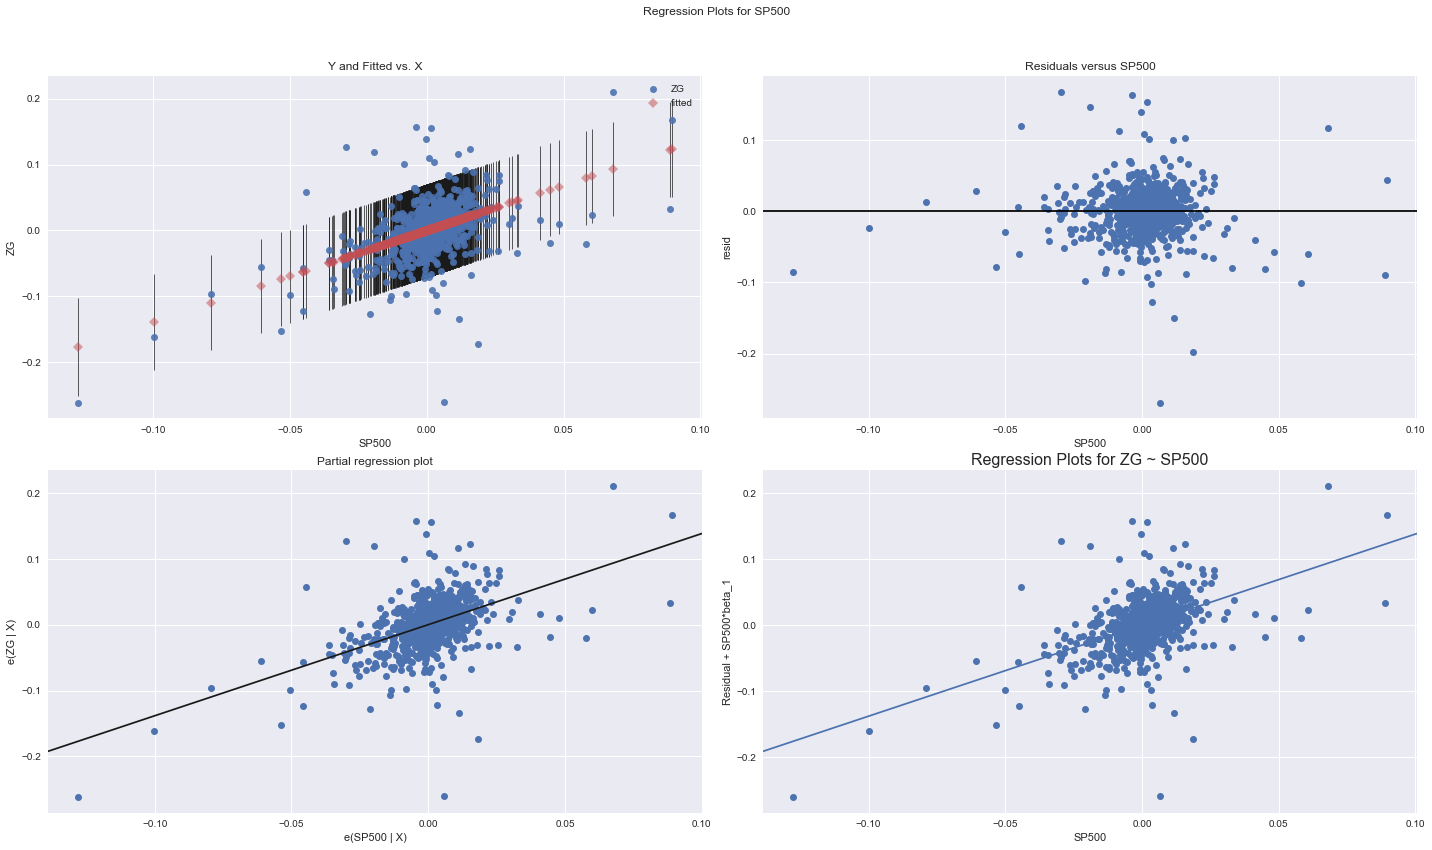

In [32]:
fig2 = plt.figure(figsize=(20,12))
fig2 = sm.graphics.plot_regress_exog(zg_model_fit, "SP500", fig2)
plt.title('Regression Plots for ZG ~ SP500',fontsize=16)

Text(0.5, 1.0, 'Regression Plots for SQ ~ SP500')

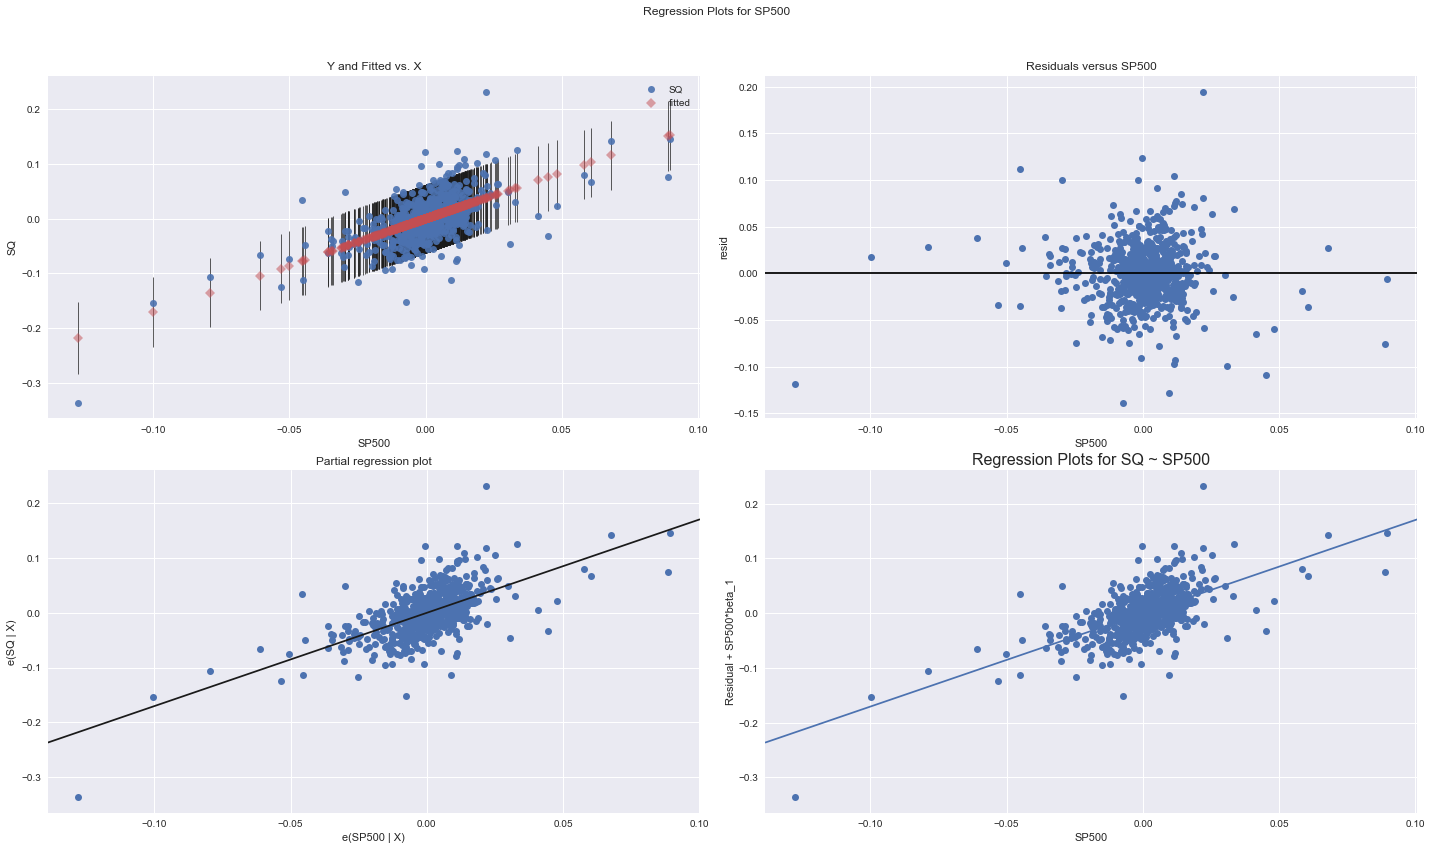

In [33]:
fig3 = plt.figure(figsize=(20,12))
fig3 = sm.graphics.plot_regress_exog(sq_model_fit, "SP500", fig3)
plt.title('Regression Plots for SQ ~ SP500',fontsize=16)

Text(0.5, 1.0, 'Regression Plots for SNAP ~ SP500')

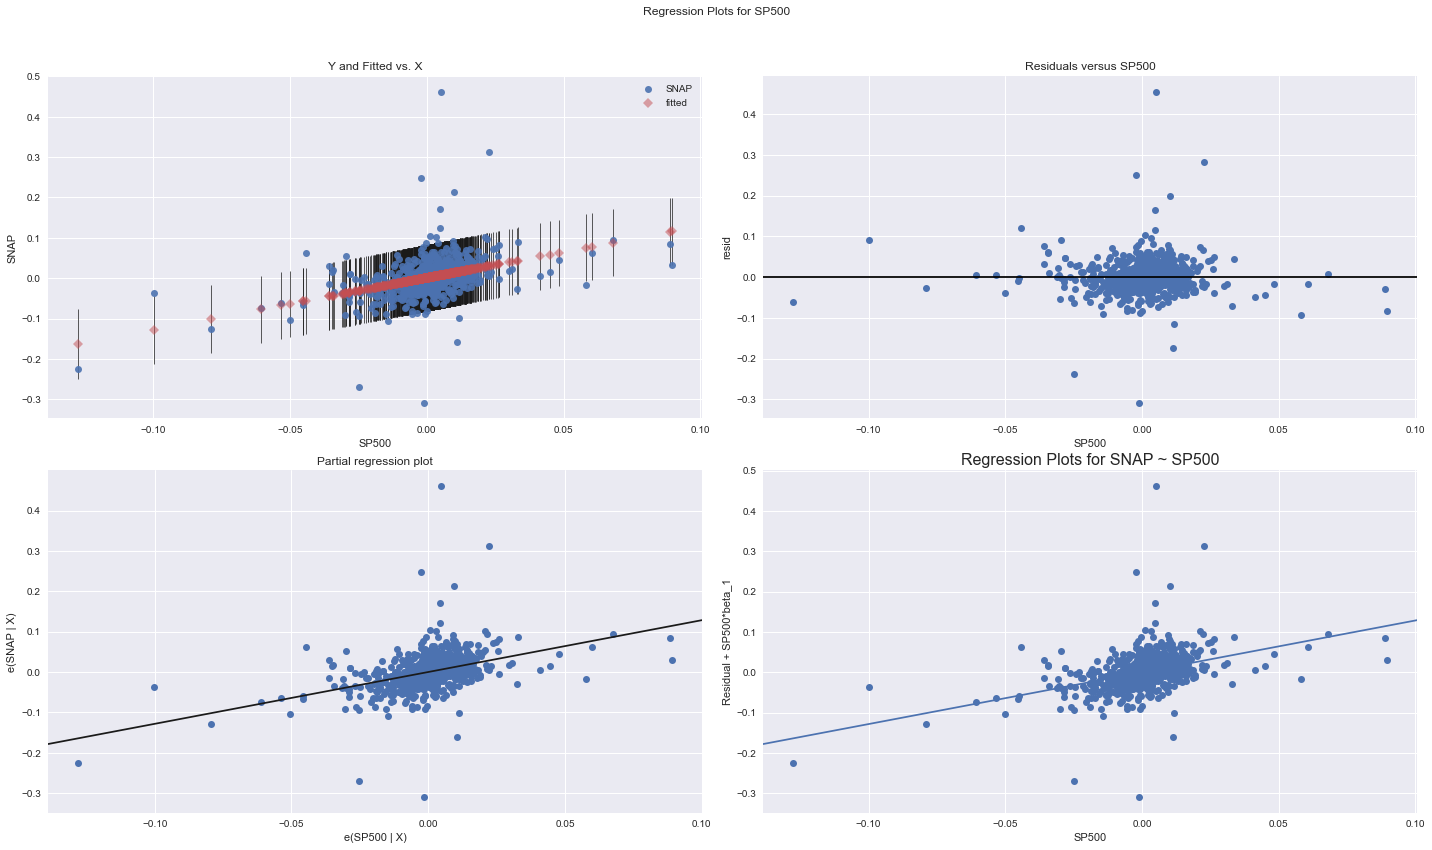

In [34]:
fig4 = plt.figure(figsize=(20,12))
fig4 = sm.graphics.plot_regress_exog(snap_model_fit, "SP500", fig4)
plt.title('Regression Plots for SNAP ~ SP500',fontsize=16)

In [35]:
model_list = [uber_model_fit, zg_model_fit, sq_model_fit, snap_model_fit]

def resid_vs_fit(df, mod_list, com_list, num_cols=2,num_rows=2,part_num=''):
    %matplotlib inline
    plt.style.use("seaborn")
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25,15))
    for i, model in enumerate(mod_list):
        ax = axes[int(i/num_cols), i%num_cols]
        y_hat = model.fittedvalues
        sns.set(rc = {'figure.figsize':(25,15)})
        res_plot = sns.residplot(x=y_hat, y=com_list[i], data=df, lowess=True, 
                             scatter_kws={'alpha': 0.65}, 
                             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=ax)

        res_plot.set_title('Residuals vs Fitted (' + com_list[i] + ' ~ SP500)',fontsize=18)
        res_plot.set_xlabel('Fitted values',fontsize=16)
        res_plot.set_ylabel('Residuals',fontsize=16)
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.22)
        
    plt.savefig('figures/part'+part_num+'_residual_plots.png')
    plt.show()

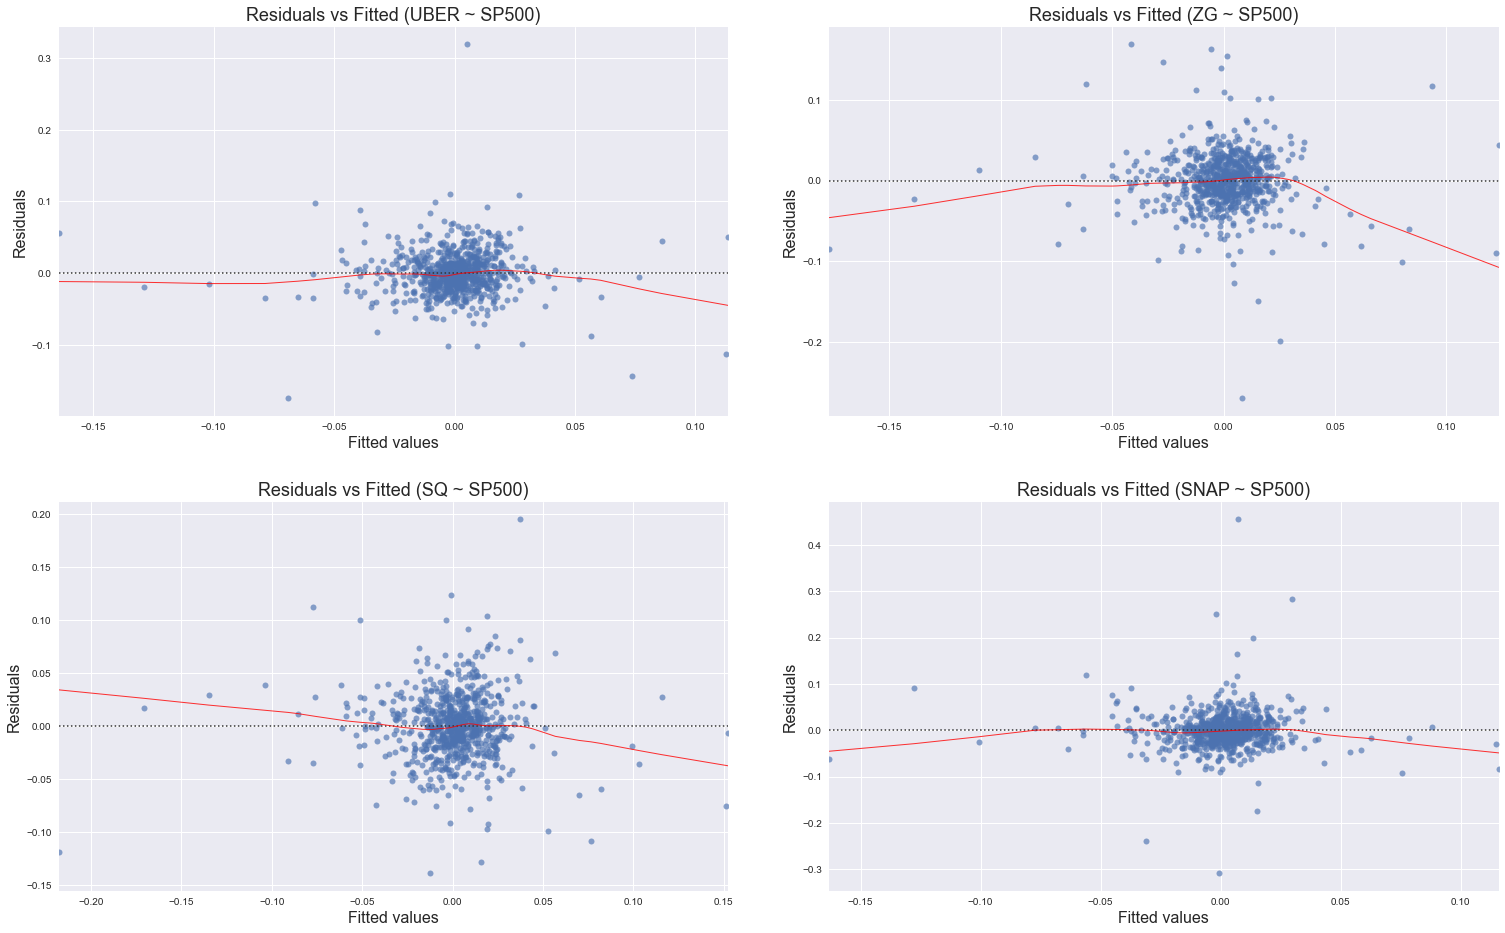

In [36]:
resid_vs_fit(df1_returns, model_list, nonSP_list, num_cols=2,num_rows=2,part_num='1')

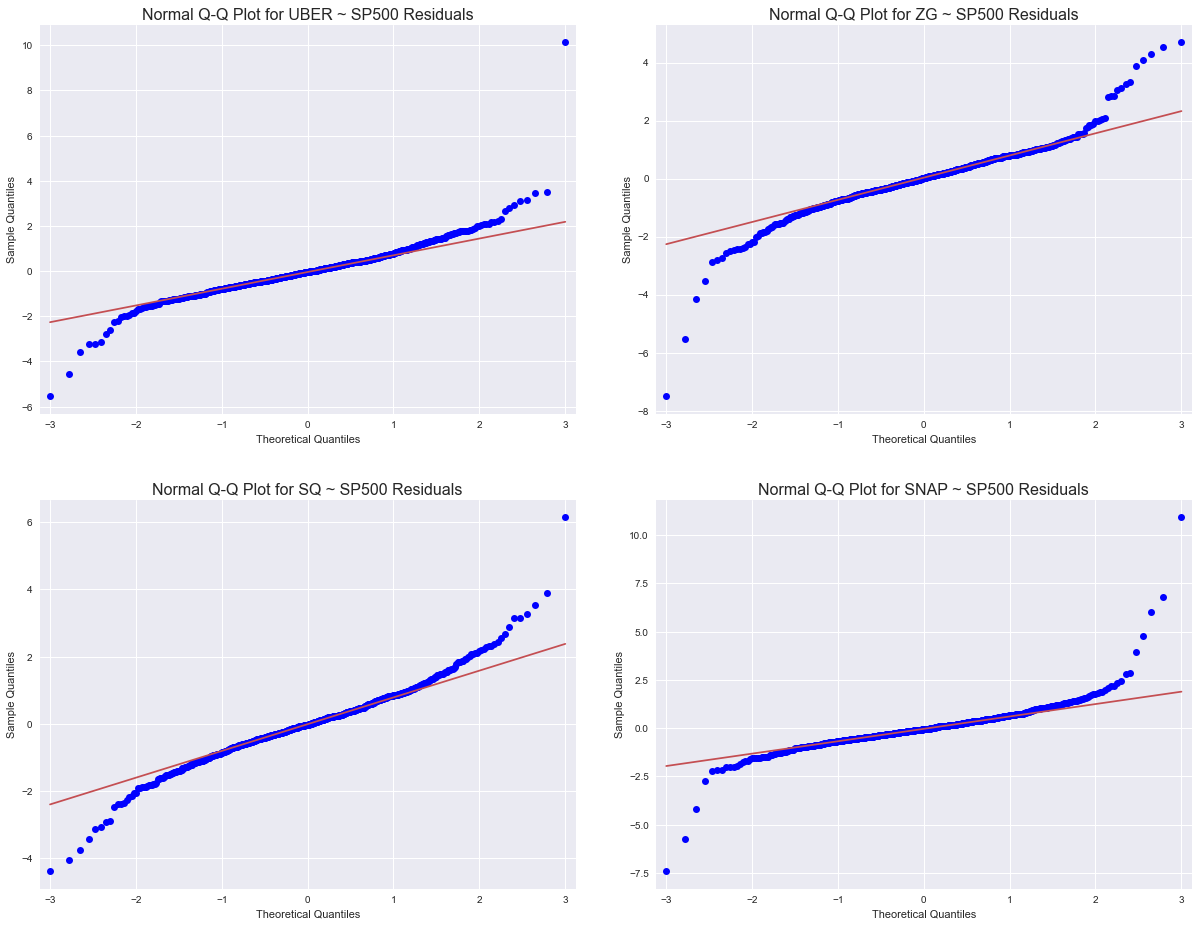

In [37]:
## Residual Q-Q Plot for each model fit
norm_qqplot(df1_returns, company_list=nonSP_list, mod_list=model_list, resid_bool=True, num_cols=2, num_rows=2, part_num='1')

<a id='part2'></a>
### Part 2: Assessing S&P 500 againt four of the largest S&P 500 companies

In [38]:
# The tech stocks we'll use for this analysis
sp_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
sp_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

start = date(2019,5,10)
end = date(2022,4,26)

for stock in sp_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [39]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
# df.tail(10)

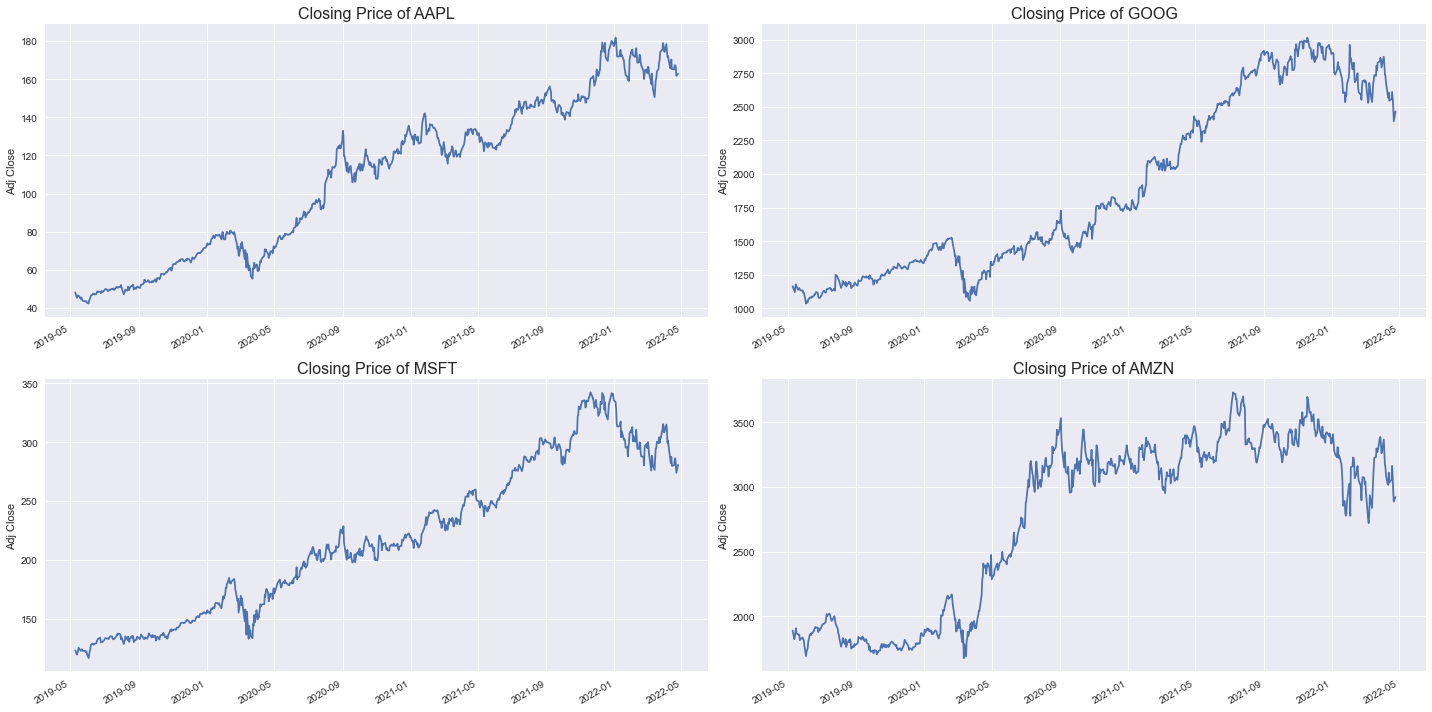

In [40]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {sp_list[i - 1]}", fontsize=16)

plt.tight_layout()

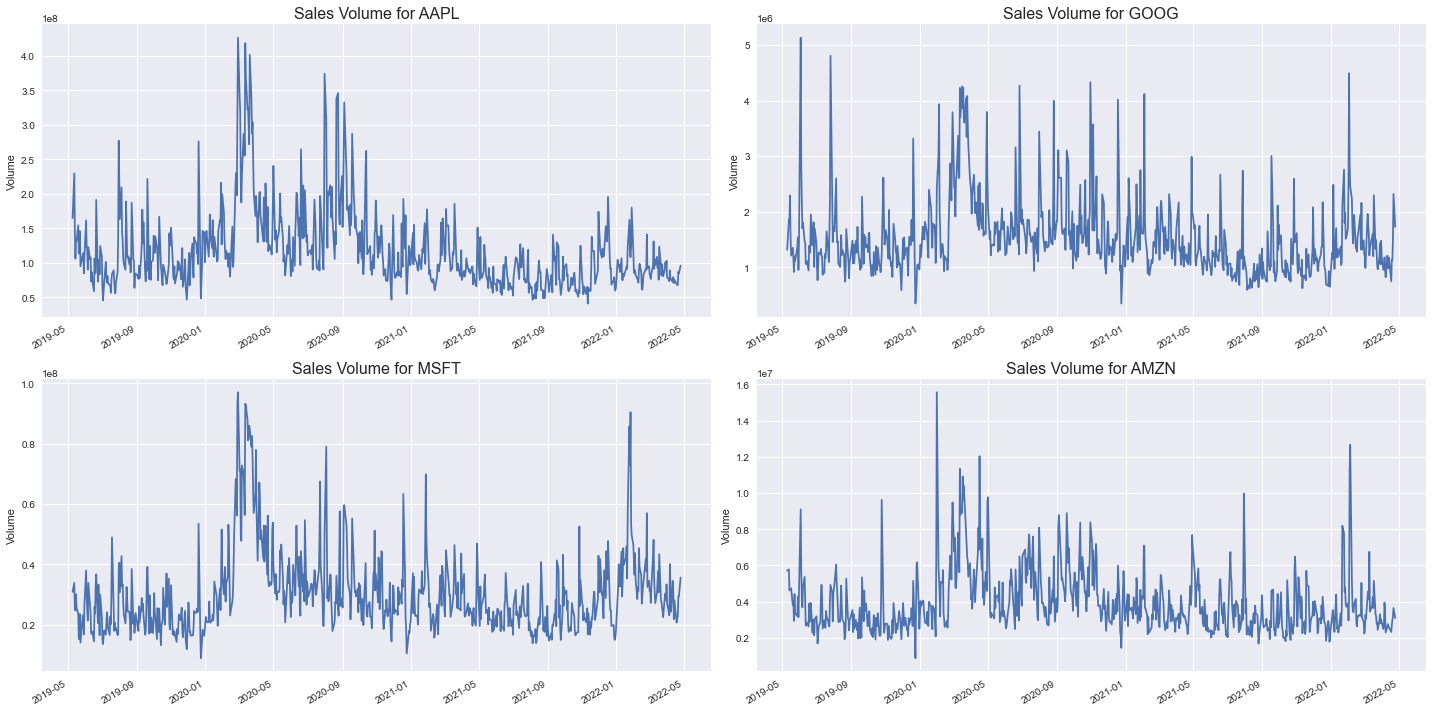

In [41]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {sp_list[i - 1]}", fontsize=16)
    
plt.tight_layout()

In [42]:
# Moving average for the various stocks
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

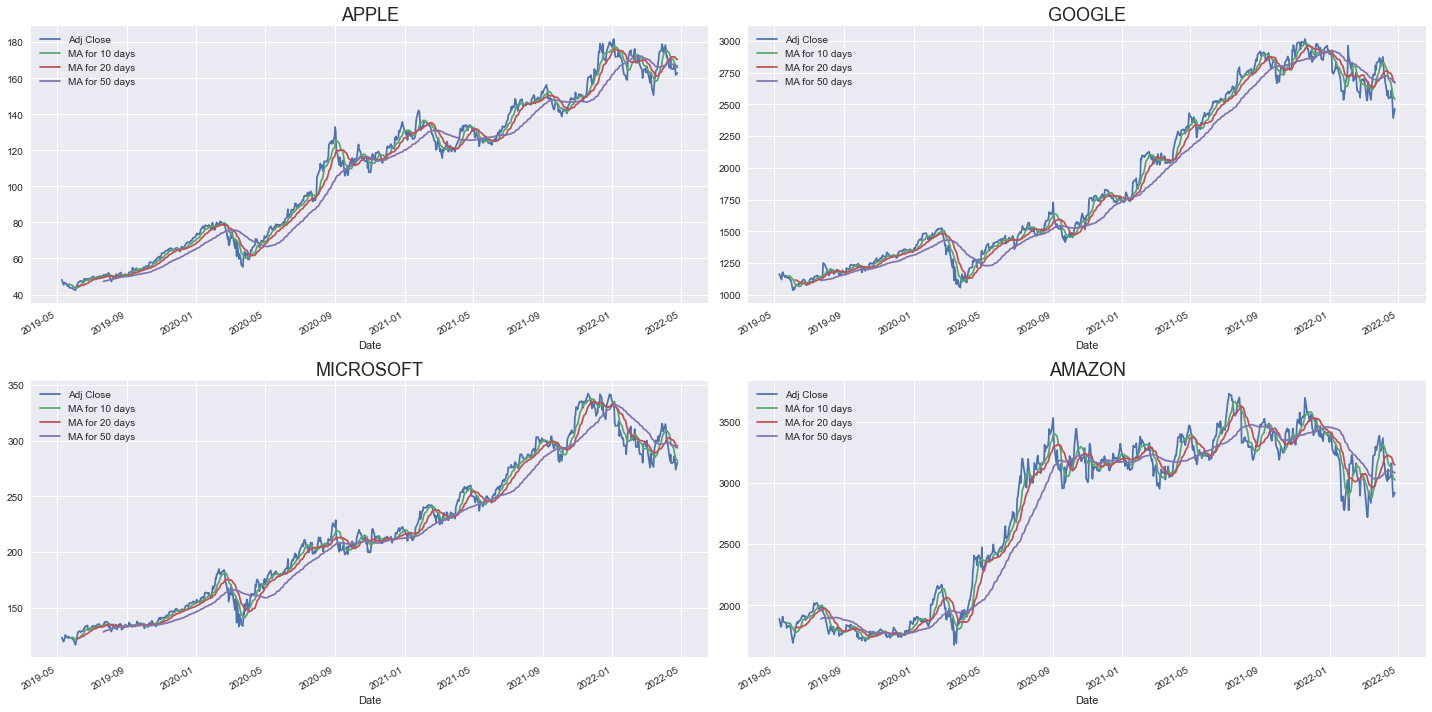

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(20)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE', fontsize=18)

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE', fontsize=18)

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT', fontsize=18)

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON', fontsize=18)

fig.tight_layout()

In [44]:
# Computes the daily log-returns for each stock:
for company in company_list:
    company['Daily Log-Return'] = np.log(company['Adj Close']) - np.log(company['Adj Close'].shift(1))

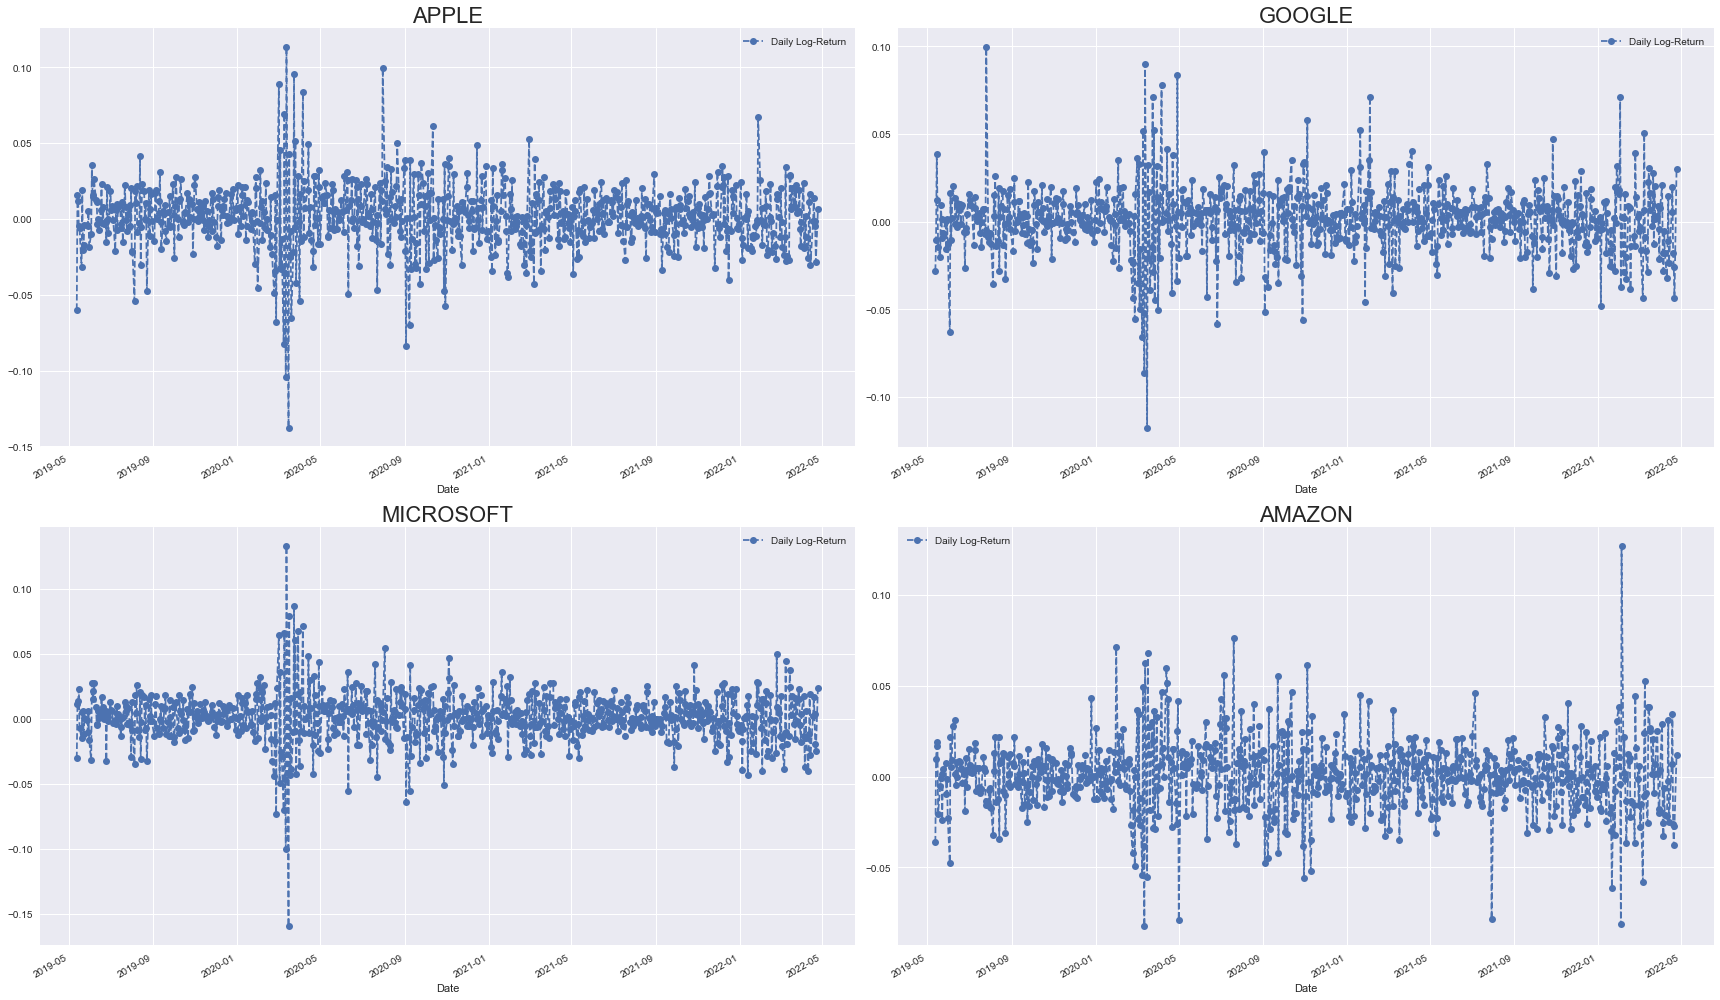

In [45]:
# Plots the daily log-returns for each stock:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(14)
fig.set_figwidth(24)

AAPL['Daily Log-Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE',fontsize=22)

GOOG['Daily Log-Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE',fontsize=22)

MSFT['Daily Log-Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT',fontsize=22)

AMZN['Daily Log-Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON',fontsize=22)

fig.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

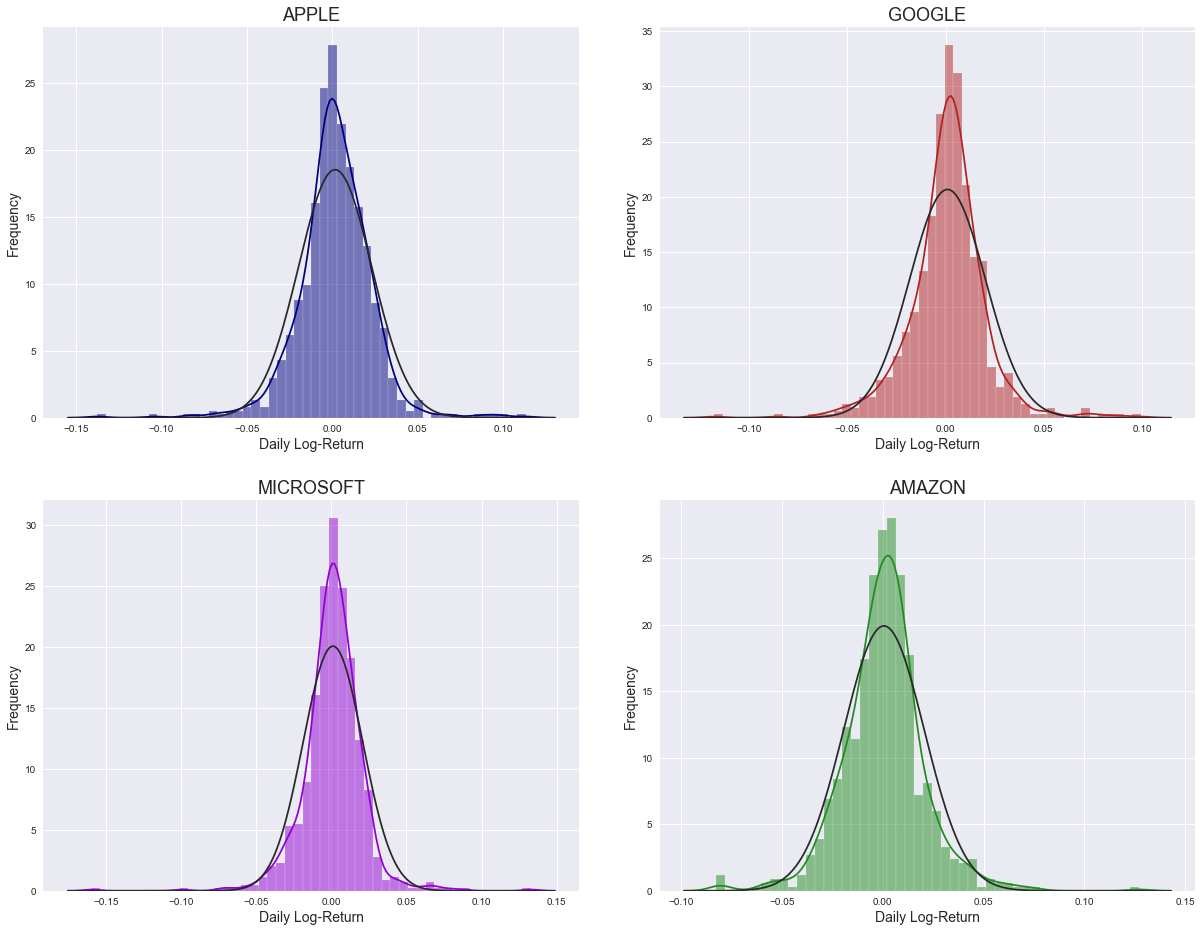

In [46]:
dens_histograms(df, company_list=company_list, company_name=company_name, sp500_stocks=True, num_cols=2, num_rows=2, part_num='2')

In [47]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(sp_list, 'yahoo', start, end)['Adj Close']

In [48]:
sp500_stocks_returns = np.log(closing_df) - np.log(closing_df.shift(1))
sp500_stocks_returns = sp500_stocks_returns[1:] #remove the NaN value at position 0
sp500_stocks_returns['SP500']=df1_returns['SP500'] # Add S&P 500 Log-Returns to the dataframe
sp500_stocks_returns

Symbols,AAPL,GOOG,MSFT,AMZN,SP500
Date,,,,,
2019-05-13,-0.059877,-0.028082,-0.030184,-0.036258,-0.024427
2019-05-14,0.015707,-0.010291,0.011126,0.009523,0.007984
2019-05-15,0.011908,0.038321,0.013984,0.016722,0.005822
2019-05-16,-0.004409,0.012607,0.022829,0.019277,0.008856
2019-05-17,-0.005698,-0.014249,-0.006692,-0.020427,-0.005854
...,...,...,...,...,...
2022-04-20,-0.001016,-0.017664,0.003708,-0.026386,-0.000619
2022-04-21,-0.004855,-0.026133,-0.019571,-0.037729,-0.014863
2022-04-22,-0.028216,-0.043544,-0.024441,-0.026969,-0.028132


One-Sample W-W Runs Test:

In [49]:
runs_test(df=sp500_stocks_returns, com_list=sp_list)

Runs test for AAPL
test stat:  0.6667143747112885
p-value:    0.5049545950991698 


Runs test for GOOG
test stat:  1.4669419891469084
p-value:    0.14239183682296772 


Runs test for MSFT
test stat:  1.8371016177472734
p-value:    0.06619489540493957 


Runs test for AMZN
test stat:  -0.49729855464411515
p-value:    0.6189785308509335 




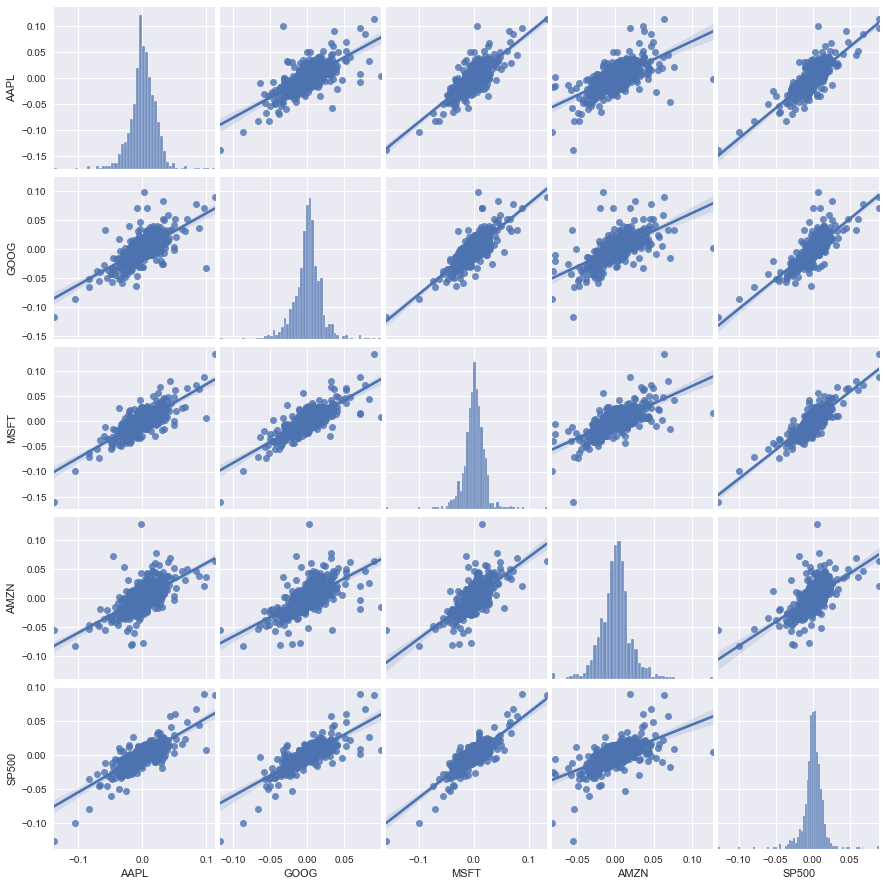

In [50]:
sns.pairplot(sp500_stocks_returns, kind='reg')
plt.savefig('figures/SP_pairplot.png')

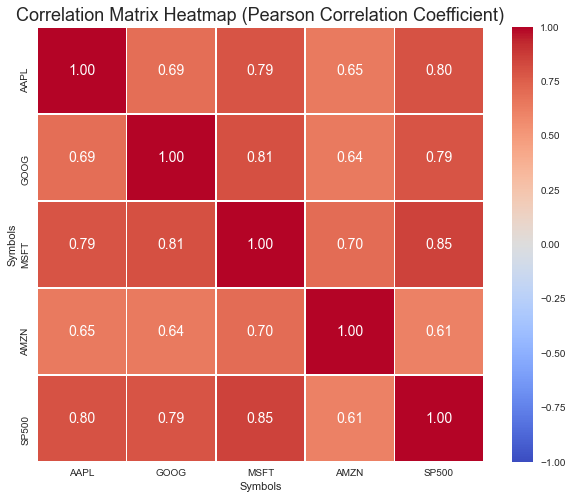

In [51]:
title = 'Correlation Matrix Heatmap (Pearson Correlation Coefficient)'
df_x = sp500_stocks_returns.copy()
matrix_x = df_x.corr(method='pearson')

## Plot heatmap of the correlation matrix
plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix_x,vmin=-1, vmax=1, cmap='coolwarm',fmt= '0.2f', 
                 annot_kws={"size":14}, linewidth=0.5, annot=True)
# sns.set(font_scale=3.3) 
plt.title(title,fontsize=18)

plt.savefig('figures/pearson_corr_heatmap_SP500_stocks.png',bbox_inches='tight')

Below we test the equality of two population means using two methodologies. Both of which assume indepence of the two distributions. In this case, this assumption cannot be satisfied since each of stocks are part of the S&P 500. Nonetheless, we evaluate the result, and subsequently perform a similar test for paired data. 

In [52]:
one_way_anova(df=sp500_stocks_returns, com_list=sp_list)

One-Way ANOVA tests the equality of two population means 

One-Way ANOVA Test for AAPL and SP500
F-statistic:  1.2853037127592648
p-value:      0.25709759768210627 


One-Way ANOVA Test for GOOG and SP500
F-statistic:  0.2750501370479101
p-value:      0.6000420507853226 


One-Way ANOVA Test for MSFT and SP500
F-statistic:  0.3745317847037306
p-value:      0.5406377319200435 


One-Way ANOVA Test for AMZN and SP500
F-statistic:  0.0006841895729427728
p-value:      0.9791356017068344 




In [53]:
# Test equality of two population means (independent populations)
eq_means_t_test(df=sp500_stocks_returns, com_list=sp_list)

This also tests the equality of two population means 

T-test for Means of AAPL and SP500
t-statistic:  1.1337123589161686
p-value:      0.2570975976819699 


T-test for Means of GOOG and SP500
t-statistic:  0.5244522257059363
p-value:      0.6000420507855098 


T-test for Means of MSFT and SP500
t-statistic:  0.6119900201014152
p-value:      0.5406377319203652 


T-test for Means of AMZN and SP500
t-statistic:  0.02615701766147555
p-value:      0.9791356017064091 




In [54]:
paired_data_t_test(sp500_stocks_returns,com_list=sp_list)

This tests the equality of means from paired data 

T-test of Means within Paired data for AAPL and SP500
t-statistic:  2.263063736449598
p-value:      0.02391878491957494 


T-test of Means within Paired data for GOOG and SP500
t-statistic:  1.0819527723665603
p-value:      0.2796235931023838 


T-test of Means within Paired data for MSFT and SP500
t-statistic:  1.4234695083745925
p-value:      0.15501873951159428 


T-test of Means within Paired data for AMZN and SP500
t-statistic:  0.04050315565624632
p-value:      0.9677028428941123 




##### Fit Linear Regression Models for S&P 500 stocks
For each S&P 500 stock, a simple linear regression of the log-returns of the stock on the S&P 500 log-returns is fit.

In [55]:
# Linear Regression of AAPL log-returns (dep. variable) on SP500 log-returns (ind. variable)
aapl_lr = smf.ols(formula='AAPL ~ SP500', data=sp500_stocks_returns)
aapl_model_fit = aapl_lr.fit()
print(aapl_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1357.
Date:                Sun, 01 May 2022   Prob (F-statistic):          6.72e-170
Time:                        05:38:51   Log-Likelihood:                 2191.4
No. Observations:                 746   AIC:                            -4379.
Df Residuals:                     744   BIC:                            -4370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.000      2.121      0.0

In [56]:
# Linear Regression of ZG log-returns (dep. variable) on SP500 log-returns (ind. variable)
goog_lr = smf.ols(formula='GOOG ~ SP500', data=sp500_stocks_returns)
goog_model_fit = goog_lr.fit()
print(goog_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1262.
Date:                Sun, 01 May 2022   Prob (F-statistic):          1.99e-162
Time:                        05:38:52   Log-Likelihood:                 2255.6
No. Observations:                 746   AIC:                            -4507.
Df Residuals:                     744   BIC:                            -4498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.000      1.036      0.3

In [57]:
# Linear Regression of SQ log-returns (dep. variable) on SP500 log-returns (ind. variable)
msft_lr = smf.ols(formula='MSFT ~ SP500', data=sp500_stocks_returns)
msft_model_fit = msft_lr.fit()
print(msft_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1977.
Date:                Sun, 01 May 2022   Prob (F-statistic):          1.16e-211
Time:                        05:38:52   Log-Likelihood:                 2346.5
No. Observations:                 746   AIC:                            -4689.
Df Residuals:                     744   BIC:                            -4680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.257      0.2

In [58]:
# Linear Regression of SNAP log-returns (dep. variable) on SP500 log-returns (ind. variable)
amzn_lr = smf.ols(formula='AMZN ~ SP500', data=sp500_stocks_returns)
amzn_model_fit = amzn_lr.fit()
print(amzn_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     443.2
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.53e-77
Time:                        05:38:52   Log-Likelihood:                 2031.2
No. Observations:                 746   AIC:                            -4058.
Df Residuals:                     744   BIC:                            -4049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.001      0.184      0.8

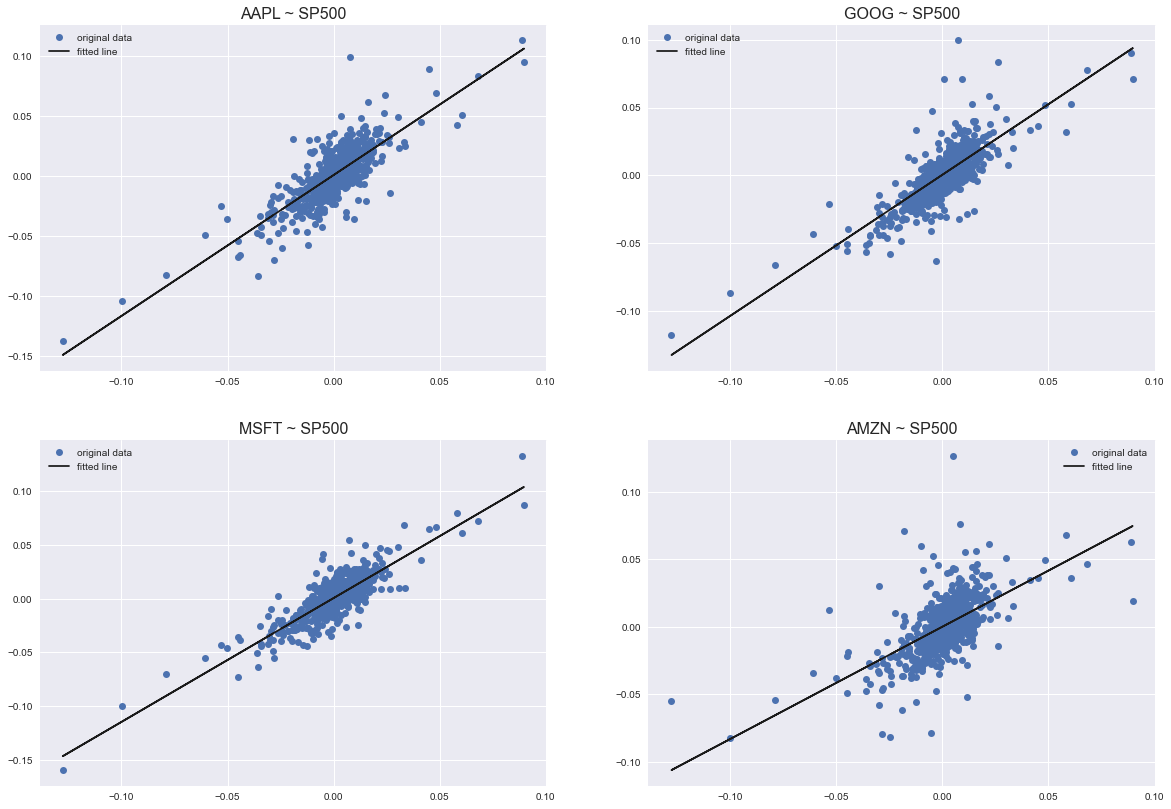

In [59]:
model_list2 = [aapl_model_fit, goog_model_fit, msft_model_fit, amzn_model_fit]
lr_plots(df=sp500_stocks_returns, mod_list=model_list2, com_list=sp_list, num_cols=2,num_rows=2,part_num='2')

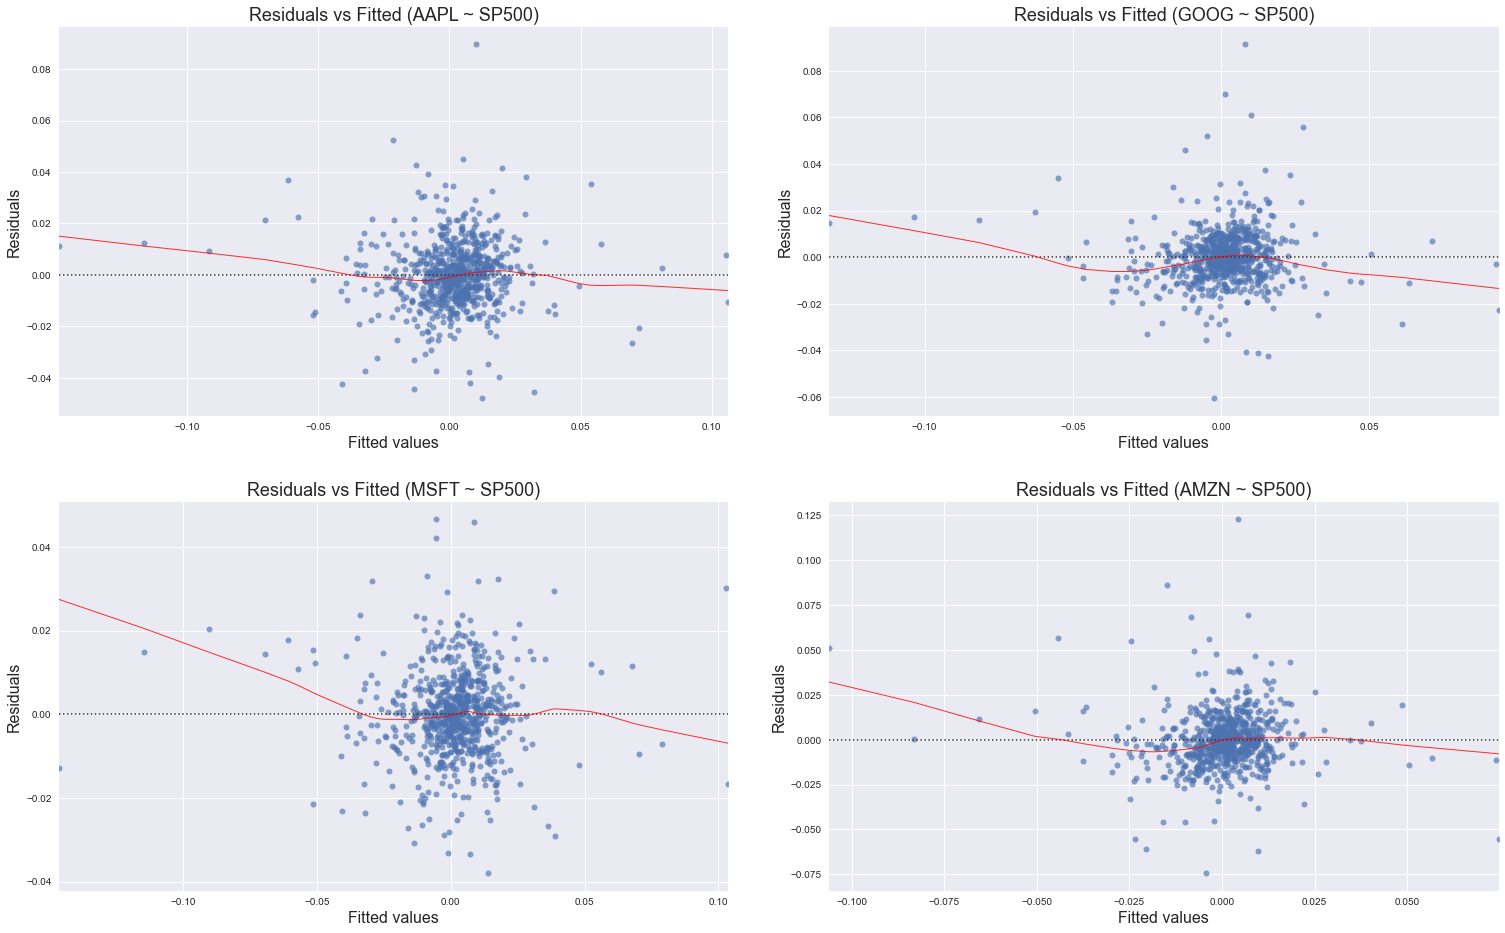

In [60]:
resid_vs_fit(df=sp500_stocks_returns, mod_list=model_list2, com_list=sp_list, num_cols=2,num_rows=2,part_num='2')

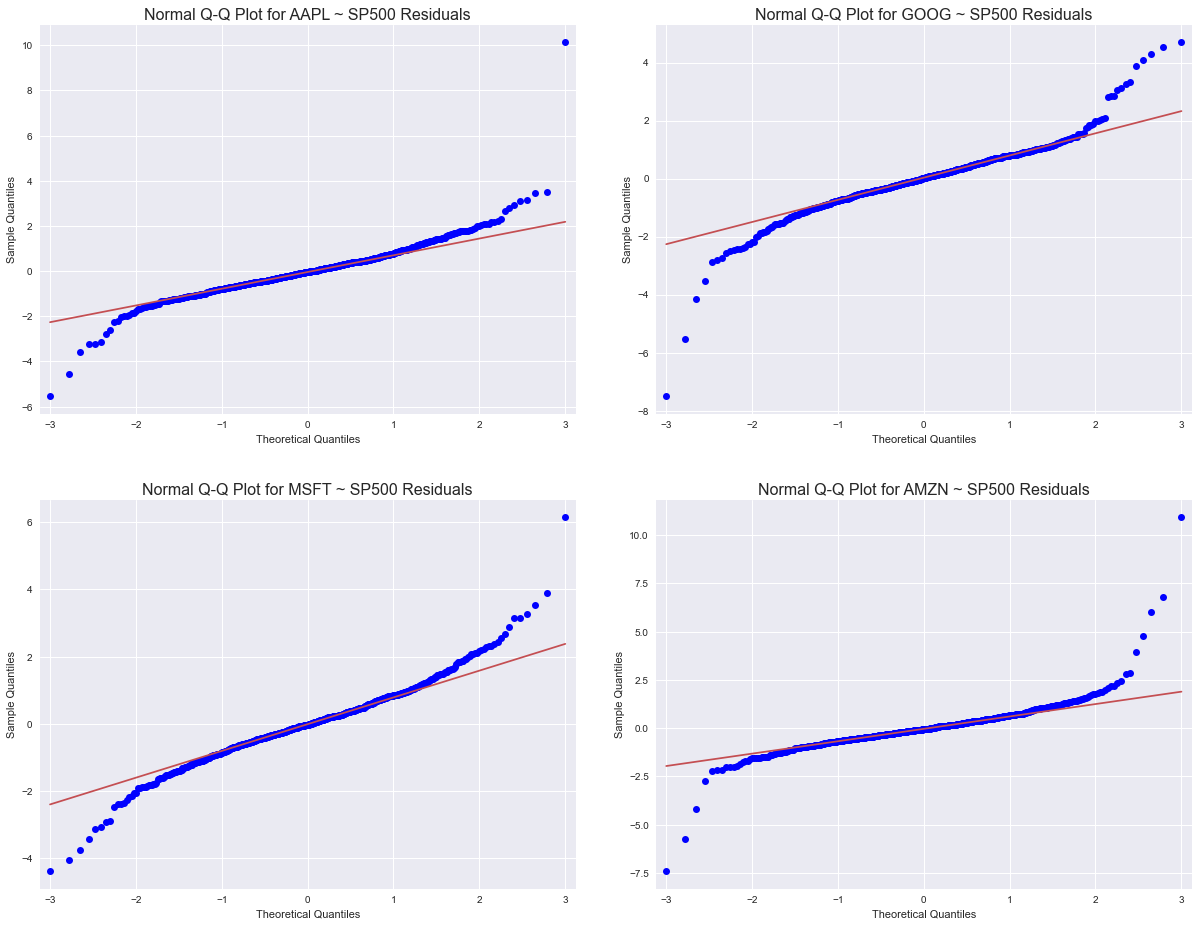

In [61]:
norm_qqplot(df, company_list=sp_list, mod_list=model_list2, resid_bool=True, num_cols=2, num_rows=2, part_num='2')

<a id='part3'></a>
### Part 3: Regression of log-returns on time

In [62]:
# First need to create a time variable via a numpy array.
time_seq = np.arange(1,len(df1_returns)+1,1)

# Remove SP500 from one of the dataframes so that there aren't two instances of it when combining.
df2_returns = sp500_stocks_returns[['AAPL','GOOG','MSFT','AMZN']]

In [63]:
# Combine all log-returns from parts 1 and 2 and the time variable created in the cell above
df_all = pd.concat([df1_returns, df2_returns], axis=1)
df_all['time'] = time_seq.tolist()

In [64]:
df_all

,UBER,ZG,SQ,SNAP,SP500,AAPL,GOOG,MSFT,AMZN,time
Date,,,,,,,,,,
2019-05-13,-0.113762,0.001411,-0.056098,-0.036897,-0.024427,-0.059877,-0.028082,-0.030184,-0.036258,1
2019-05-14,0.074262,0.030002,0.027195,0.036897,0.007984,0.015707,-0.010291,0.011126,0.009523,2
2019-05-15,0.032741,0.046520,0.017319,0.016076,0.005822,0.011908,0.038321,0.013984,0.016722,3
2019-05-16,0.040580,0.014266,0.017778,0.068868,0.008856,-0.004409,0.012607,0.022829,0.019277,4
2019-05-17,-0.025676,0.024171,-0.016552,0.006111,-0.005854,-0.005698,-0.014249,-0.006692,-0.020427,5
...,...,...,...,...,...,...,...,...,...,...
2022-04-20,-0.017610,-0.066529,-0.092512,-0.089203,-0.000619,-0.001016,-0.017664,0.003708,-0.026386,742
2022-04-21,-0.047165,-0.042629,-0.061307,-0.044540,-0.014863,-0.004855,-0.026133,-0.019571,-0.037729,743
2022-04-22,-0.027197,-0.015433,-0.047922,0.011490,-0.028132,-0.028216,-0.043544,-0.024441,-0.026969,744


For each stock, a regression of the log-return on time is computed below.

In [65]:
sp500_time_lr = smf.ols(formula='SP500 ~ time', data=df_all)
sp500_time_model_fit = sp500_time_lr.fit()
print(sp500_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09656
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.756
Time:                        05:38:55   Log-Likelihood:                 2087.4
No. Observations:                 746   AIC:                            -4171.
Df Residuals:                     744   BIC:                            -4162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.001      0.729      0.4

In [66]:
uber_time_lr = smf.ols(formula='UBER ~ time', data=df_all)
uber_time_model_fit = uber_time_lr.fit()
print(uber_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   UBER   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06707
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.796
Time:                        05:38:55   Log-Likelihood:                 1406.6
No. Observations:                 746   AIC:                            -2809.
Df Residuals:                     744   BIC:                            -2800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.003      0.084      0.9

In [67]:
zg_time_lr = smf.ols(formula='ZG ~ time', data=df_all)
zg_time_model_fit = zg_time_lr.fit()
print(zg_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     ZG   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.416
Date:                Sun, 01 May 2022   Prob (F-statistic):             0.0650
Time:                        05:38:55   Log-Likelihood:                 1321.7
No. Observations:                 746   AIC:                            -2639.
Df Residuals:                     744   BIC:                            -2630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0049      0.003      1.639      0.1

In [68]:
sq_time_lr = smf.ols(formula='SQ ~ time', data=df_all)
sq_time_model_fit = sq_time_lr.fit()
print(sq_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     SQ   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.977
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.160
Time:                        05:38:55   Log-Likelihood:                 1335.5
No. Observations:                 746   AIC:                            -2667.
Df Residuals:                     744   BIC:                            -2658.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0042      0.003      1.408      0.1

In [69]:
snap_time_lr = smf.ols(formula='SNAP ~ time', data=df_all)
snap_time_model_fit = snap_time_lr.fit()
print(snap_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   SNAP   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.319
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.128
Time:                        05:38:55   Log-Likelihood:                 1243.5
No. Observations:                 746   AIC:                            -2483.
Df Residuals:                     744   BIC:                            -2474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.003      1.721      0.0

In [70]:
aapl_time_lr = smf.ols(formula='AAPL ~ time', data=df_all)
aapl_time_model_fit = aapl_time_lr.fit()
print(aapl_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7357
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.391
Time:                        05:38:55   Log-Likelihood:                 1804.5
No. Observations:                 746   AIC:                            -3605.
Df Residuals:                     744   BIC:                            -3596.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0028      0.002      1.744      0.0

In [71]:
goog_time_lr = smf.ols(formula='GOOG ~ time', data=df_all)
goog_time_model_fit = goog_time_lr.fit()
print(goog_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2193
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.640
Time:                        05:38:55   Log-Likelihood:                 1885.7
No. Observations:                 746   AIC:                            -3767.
Df Residuals:                     744   BIC:                            -3758.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.001      1.086      0.2

In [72]:
msft_time_lr = smf.ols(formula='MSFT ~ time', data=df_all)
msft_time_model_fit = msft_time_lr.fit()
print(msft_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7192
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.397
Time:                        05:38:55   Log-Likelihood:                 1863.2
No. Observations:                 746   AIC:                            -3722.
Df Residuals:                     744   BIC:                            -3713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0021      0.001      1.455      0.1

In [73]:
amzn_time_lr = smf.ols(formula='AMZN ~ time', data=df_all)
amzn_time_model_fit = amzn_time_lr.fit()
print(amzn_time_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9226
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.337
Time:                        05:38:55   Log-Likelihood:                 1857.4
No. Observations:                 746   AIC:                            -3711.
Df Residuals:                     744   BIC:                            -3702.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.001      1.186      0.2

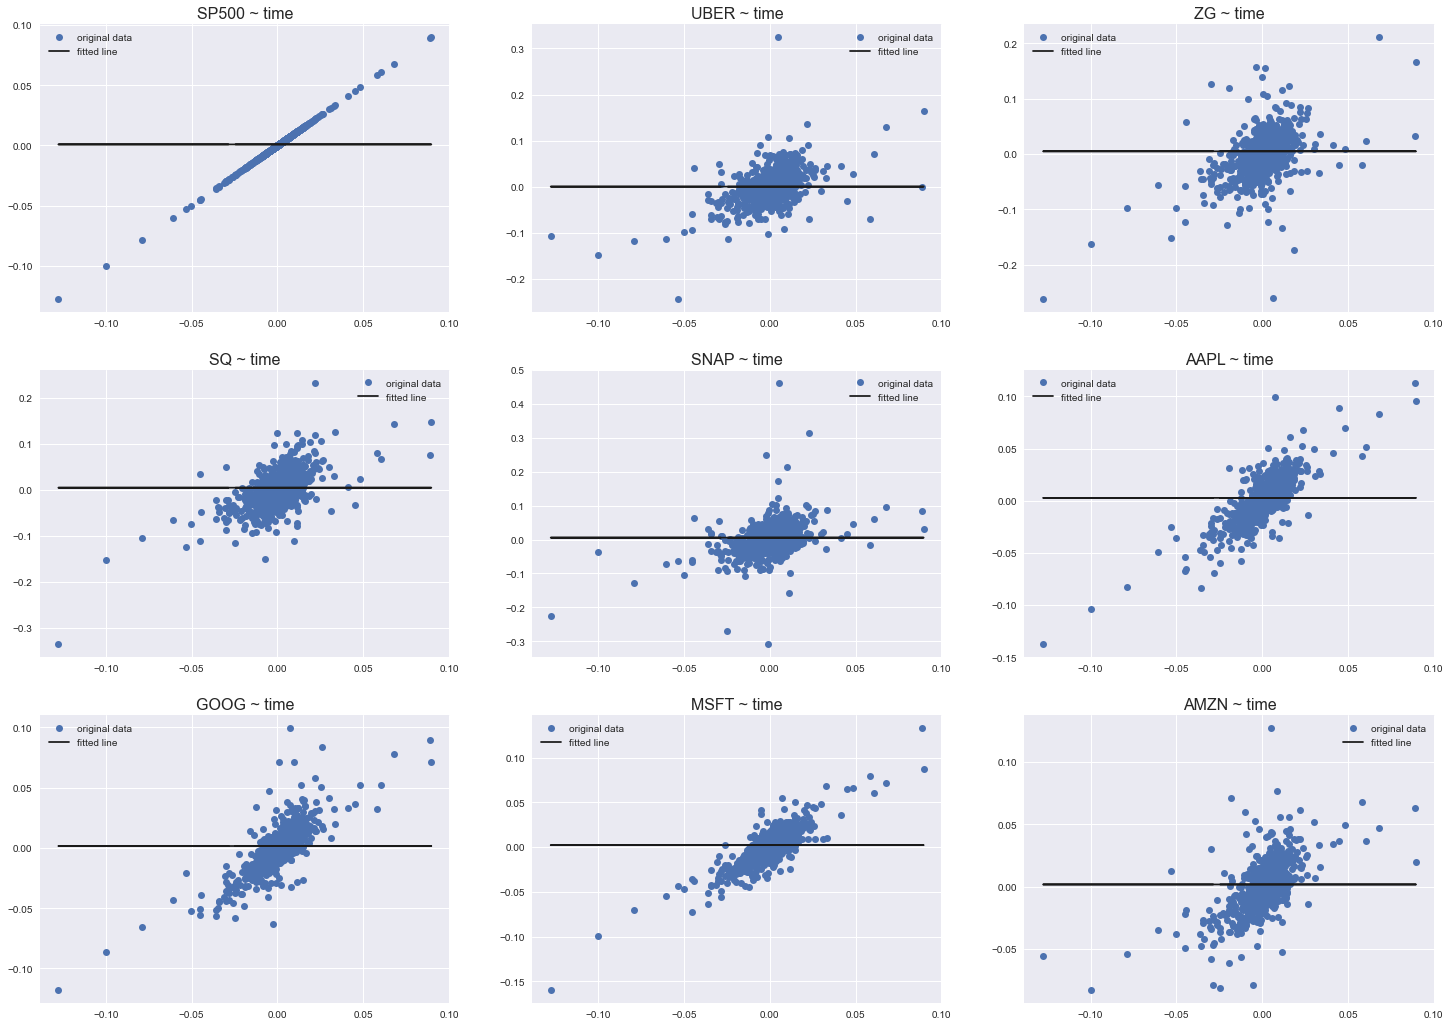

In [74]:
model_list3 = [sp500_time_model_fit, uber_time_model_fit, zg_time_model_fit, sq_time_model_fit, 
               snap_time_model_fit, aapl_time_model_fit, goog_time_model_fit, msft_time_model_fit, 
               amzn_time_model_fit]
all_list = ['SP500','UBER','ZG','SQ','SNAP','AAPL','GOOG','MSFT','AMZN']
lr_plots(df=df_all, mod_list=model_list3, com_list=all_list, num_cols=3,num_rows=3,
         part_num='3',fig_size=(25,18), time_bool=True)

<a id='part4'></a>
### Part 4: Assess S&P 500 against U.S. National Housing Price Index (HPI)

In [75]:
## Read in monthly average S&P 500 prices and U.S. HPI data (both sourced from FRED)
sp500_monthly_df = pd.read_csv("./Data/SP500_10y_monthly.csv", index_col='DATE')  # S&P 500
sp500_monthly_df.index = pd.to_datetime(sp500_monthly_df.index)

hpi_df = pd.read_csv("./Data/CSUSHPISA_10y.csv", index_col='DATE')   # U.S. National HPI
hpi_df.index = pd.to_datetime(hpi_df.index) 

In [76]:
# Compute log-returns of S&P 500:
sp500_monthly_df['SP500_Monthly_Log_Return'] = np.log(sp500_monthly_df['SP500']) - np.log(sp500_monthly_df['SP500'].shift(1))
sp500_returns = sp500_monthly_df['SP500_Monthly_Log_Return']

In [77]:
df3 = pd.concat([sp500_monthly_df, hpi_df], axis=1)
df3= df3[1:]

In [78]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2012-06-01 to 2022-02-01
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SP500                     117 non-null    float64
 1   SP500_Monthly_Log_Return  117 non-null    float64
 2   CSUSHPISA                 117 non-null    float64
dtypes: float64(3)
memory usage: 3.7 KB


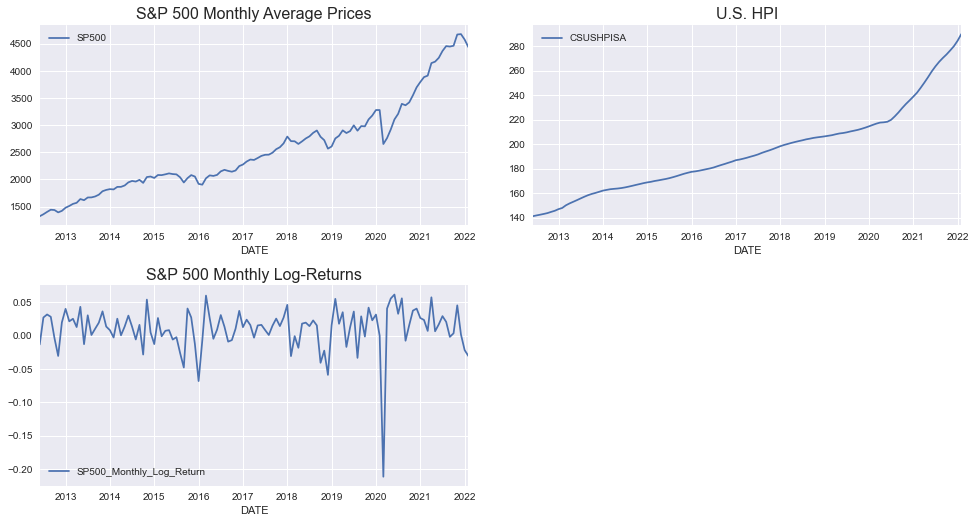

In [79]:
%matplotlib inline
plt.style.use("seaborn")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
fig.delaxes(axes[1,1]) 

df3[['SP500']].plot(ax=axes[0][0])
axes[0][0].set_title('S&P 500 Monthly Average Prices', fontsize=16)

df3[['CSUSHPISA']].plot(ax=axes[0][1])
axes[0][1].set_title('U.S. HPI', fontsize=16)

df3[['SP500_Monthly_Log_Return']].plot(ax=axes[1][0])
axes[1][0].set_title('S&P 500 Monthly Log-Returns', fontsize=16)

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.15,hspace=0.3)
plt.savefig('figures/hpi_sp500_comparison.png')

In [80]:
hpi_lr = smf.ols(formula='CSUSHPISA ~ SP500', data=df3)
hpi_model_fit = hpi_lr.fit()
print(hpi_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              CSUSHPISA   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     5225.
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.08e-97
Time:                        05:38:58   Log-Likelihood:                -356.64
No. Observations:                 117   AIC:                             717.3
Df Residuals:                     115   BIC:                             722.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     89.3215      1.521     58.716      0.0

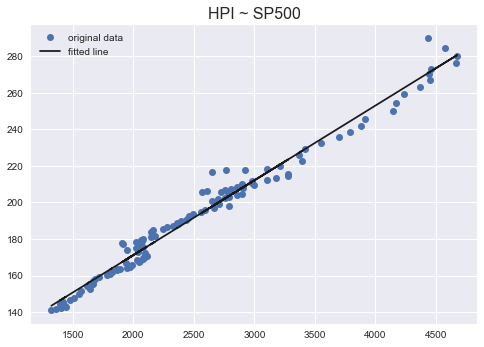

In [81]:
# Fitted line against realized values
intercept = hpi_model_fit.params[0]
slope=hpi_model_fit.params[1]
x = df3.SP500
y = df3['CSUSHPISA']
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'k', label='fitted line')
plt.title('HPI ~ SP500',fontsize=16)
plt.legend()
    
plt.savefig('figures/HPI_lr_plot.png')
plt.show()

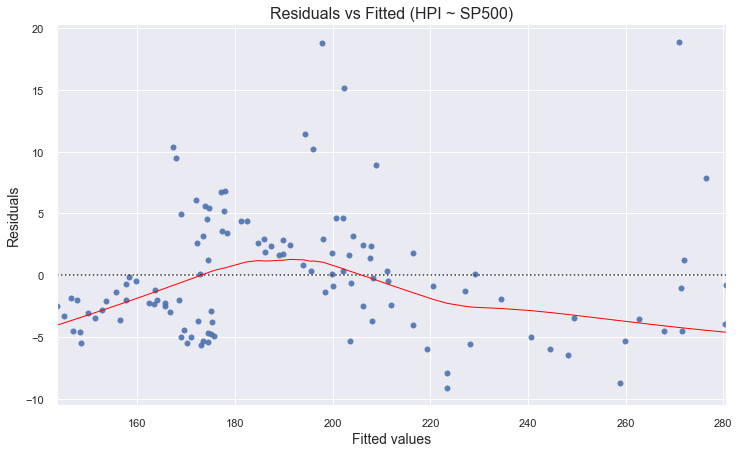

In [82]:
y_hat = hpi_model_fit.fittedvalues
sns.set(rc = {'figure.figsize':(12,7)})
res_plot = sns.residplot(x=y_hat, y='CSUSHPISA', data=df3, lowess=True, 
                        scatter_kws={'alpha': 0.9}, 
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 1.0})

res_plot.set_title('Residuals vs Fitted (HPI ~ SP500)',fontsize=16)
res_plot.set_xlabel('Fitted values',fontsize=14)
res_plot.set_ylabel('Residuals',fontsize=14)

plt.savefig('figures/hpi_residual_plot.png')
plt.show()

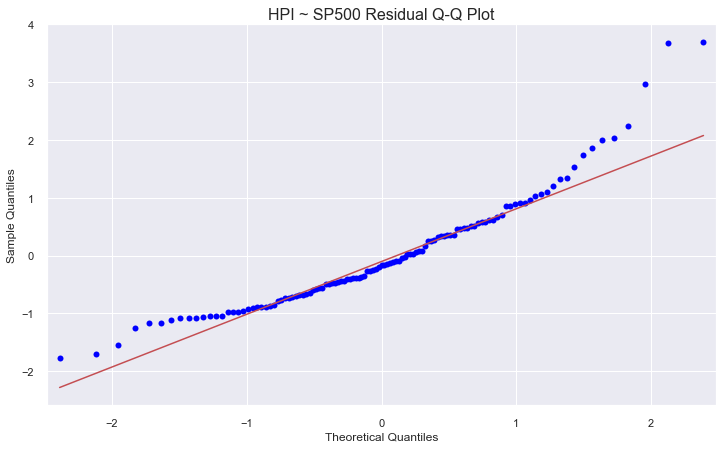

In [83]:
## Q-Q plot of residuals to assess normality of the residuals
qqplot(hpi_model_fit.resid, dist=norm, fit=True, line ='q')
plt.title('HPI ~ SP500 Residual Q-Q Plot', fontsize=16)
plt.savefig('figures/hpi_residual_qq_plot.png')
plt.show()

In [84]:
hpi_model2 = smf.ols('CSUSHPISA ~ SP500_Monthly_Log_Return', data=df3)
hpi_model2_fit = hpi_model2.fit()
print(hpi_model2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              CSUSHPISA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                  0.001979
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.965
Time:                        05:38:59   Log-Likelihood:                -581.16
No. Observations:                 117   AIC:                             1166.
Df Residuals:                     115   BIC:                             1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

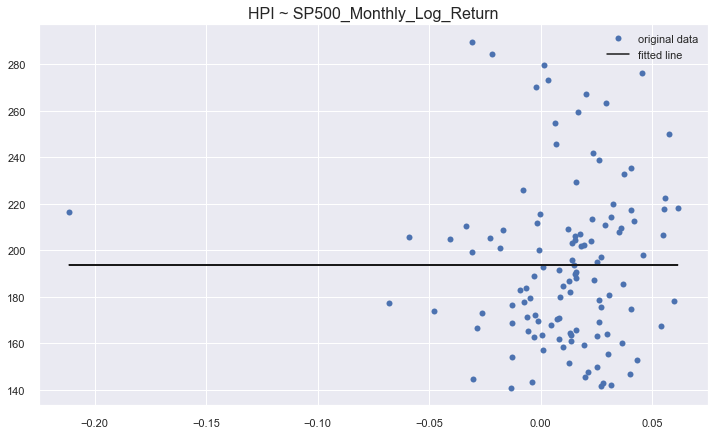

In [85]:
# Fitted line against realized values
intercept = hpi_model2_fit.params[0]
slope=hpi_model_fit.params[1]
x = df3['SP500_Monthly_Log_Return']
y = df3['CSUSHPISA']
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'k', label='fitted line')
plt.title('HPI ~ SP500_Monthly_Log_Return',fontsize=16)
plt.legend()
    
plt.savefig('figures/HPI_logreturns_lr_plot.png')
plt.show()

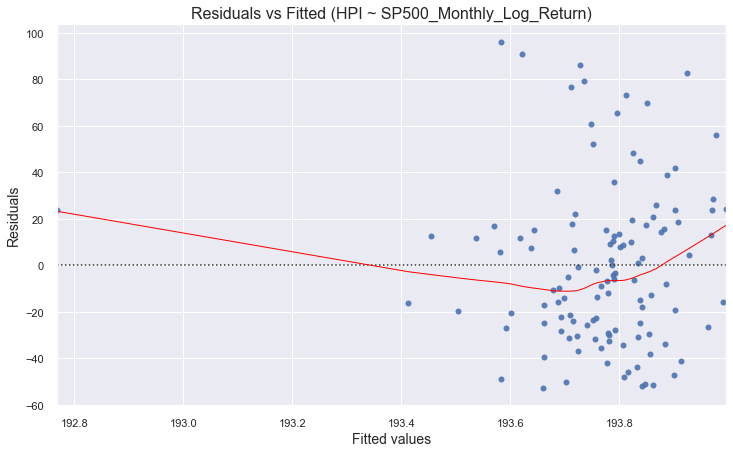

In [86]:
y_hat = hpi_model2_fit.fittedvalues
sns.set(rc = {'figure.figsize':(12,7)})
res_plot = sns.residplot(x=y_hat, y='CSUSHPISA', data=df3, lowess=True, 
                        scatter_kws={'alpha': 0.9}, 
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 1.0})

res_plot.set_title('Residuals vs Fitted (HPI ~ SP500_Monthly_Log_Return)',fontsize=16)
res_plot.set_xlabel('Fitted values',fontsize=14)
res_plot.set_ylabel('Residuals',fontsize=14)

plt.savefig('figures/hpi_logreturns_residual_plot.png')
plt.show()

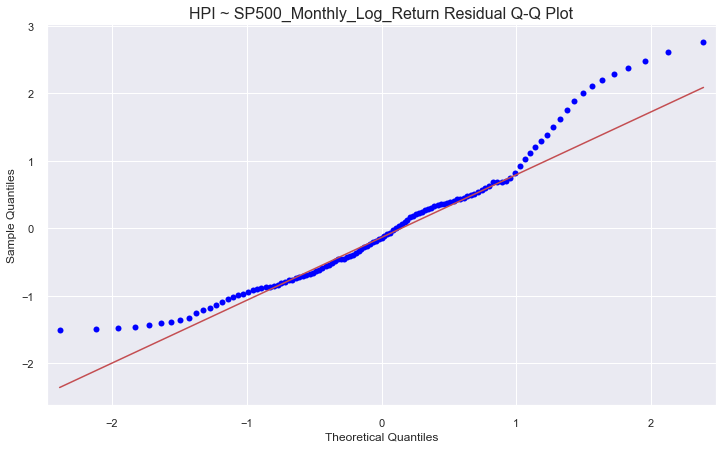

In [87]:
## Q-Q plot of residuals to assess normality of the residuals
qqplot(hpi_model2_fit.resid, dist=norm, fit=True, line ='q')
plt.title('HPI ~ SP500_Monthly_Log_Return Residual Q-Q Plot', fontsize=16)
plt.savefig('figures/hpi_logreturns_residual_qq_plot.png')
plt.show()